## Import libraries

In [1]:
!apt update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar -xvf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,243 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,383 kB]
Get:13 http://security.ubuntu.com/ubun

In [2]:
!pip install squarify
# !pip install matplotlib==3.1.3

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
# Import libraries
import pyspark
import squarify
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pyspark.sql.functions as f
from pyspark.sql.types import DateType
from pyspark.sql import SparkSession, types, SQLContext
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql.functions import *
from pyspark.sql.functions import col, log, isnan, when, count, mean, max, stddev, udf, max as spark_max, sum as Fsum, concat, round
from scipy import stats
from datetime import datetime
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.ml.feature import Binarizer, VectorAssembler, OneHotEncoder, StringIndexer, Bucketizer
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

In [6]:
import matplotlib

print(matplotlib.__version__)

3.10.0


In [7]:
sc = SparkContext()

In [8]:
spark = SparkSession(sc)

In [9]:
sql = SQLContext(sc)

/content/spark-3.3.0-bin-hadoop3/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Data Pre-Processing

### Loading Data

In [10]:
file_1 = '/content/gdrive/MyDrive/Do_An_TN/Products_with_Categories.csv'

In [11]:
# Load data using pandas
df_1 = pd.read_csv(file_1)
df_1.head(5)

,productId,productName,price,Category
0,1,tropical fruit,7.8,Fresh Food
1,2,whole milk,1.8,Dairy
2,3,pip fruit,3.0,Fresh Food
3,4,other vegetables,0.8,Fresh Food
4,5,rolls/buns,1.2,Bakery & Sweets


In [12]:
df_1.count()

,0
productId,167
productName,167
price,167
Category,167


In [13]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   productId    167 non-null    int64  
 1   productName  167 non-null    object 
 2   price        167 non-null    float64
 3   Category     167 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 5.3+ KB


In [14]:
# Check Null
is_null_1 = df_1.isnull().sum()
print(is_null_1)

productId      0
productName    0
price          0
Category       0
dtype: int64


In [15]:
file_2 = '/content/gdrive/MyDrive/Do_An_TN/Transactions.csv'

In [16]:
# Load data using pandas
df_2 = pd.read_csv(file_2)
df_2.head(5)

,Member_number,Date,productId,items
0,1808,21-07-2015,1,3
1,2552,05-01-2015,2,1
2,2300,19-09-2015,3,3
3,1187,12-12-2015,4,3
4,3037,01-02-2015,2,1


In [17]:
df_2.count()

,0
Member_number,38765
Date,38765
productId,38765
items,38765


In [18]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Member_number  38765 non-null  int64 
 1   Date           38765 non-null  object
 2   productId      38765 non-null  int64 
 3   items          38765 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.2+ MB


In [19]:
# Check Null
is_null_2 = df_2.isnull().sum()
print(is_null_2)

Member_number    0
Date             0
productId        0
items            0
dtype: int64


In [20]:
merged_df = pd.merge(df_2, df_1, on='productId', how='inner')
merged_df.head(5)

,Member_number,Date,productId,items,productName,price,Category
0,1808,21-07-2015,1,3,tropical fruit,7.8,Fresh Food
1,2552,05-01-2015,2,1,whole milk,1.8,Dairy
2,2300,19-09-2015,3,3,pip fruit,3.0,Fresh Food
3,1187,12-12-2015,4,3,other vegetables,0.8,Fresh Food
4,3037,01-02-2015,2,1,whole milk,1.8,Dairy


In [21]:
merged_df_is_null = merged_df.isnull().sum()
print(merged_df_is_null)

Member_number    0
Date             0
productId        0
items            0
productName      0
price            0
Category         0
dtype: int64


In [22]:
dup_merged_df = merged_df.duplicated().sum()
print(dup_merged_df)

244


In [23]:
new_merged_df = merged_df.drop_duplicates()
new_merged_df.head(5)

,Member_number,Date,productId,items,productName,price,Category
0,1808,21-07-2015,1,3,tropical fruit,7.8,Fresh Food
1,2552,05-01-2015,2,1,whole milk,1.8,Dairy
2,2300,19-09-2015,3,3,pip fruit,3.0,Fresh Food
3,1187,12-12-2015,4,3,other vegetables,0.8,Fresh Food
4,3037,01-02-2015,2,1,whole milk,1.8,Dairy


In [24]:
new_merged_df.describe()

,Member_number,productId,items,price
count,38521.000000,38521.000000,38521.000000,38521.000000
mean,3003.438358,40.060928,1.996729,4.305367
std,1153.573601,37.324968,0.817539,4.320088
min,1000.000000,1.000000,1.000000,0.300000
25%,2002.000000,9.000000,1.000000,1.250000
50%,3005.000000,25.000000,2.000000,2.500000
75%,4007.000000,65.000000,3.000000,6.100000
max,5000.000000,167.000000,3.000000,28.500000


In [25]:
# Use Spark to read in the csv file
data_1 = spark.read.csv(file_1, inferSchema=True, header=True)
data_1.show(5)

+---------+----------------+-----+---------------+
|productId|     productName|price|       Category|
+---------+----------------+-----+---------------+
|        1|  tropical fruit|  7.8|     Fresh Food|
|        2|      whole milk|  1.8|          Dairy|
|        3|       pip fruit|  3.0|     Fresh Food|
|        4|other vegetables|  0.8|     Fresh Food|
|        5|      rolls/buns|  1.2|Bakery & Sweets|
+---------+----------------+-----+---------------+
only showing top 5 rows



In [26]:
data_1 = data_1.withColumnRenamed('productId', 'productNo')
data_1.show(5)

+---------+----------------+-----+---------------+
|productNo|     productName|price|       Category|
+---------+----------------+-----+---------------+
|        1|  tropical fruit|  7.8|     Fresh Food|
|        2|      whole milk|  1.8|          Dairy|
|        3|       pip fruit|  3.0|     Fresh Food|
|        4|other vegetables|  0.8|     Fresh Food|
|        5|      rolls/buns|  1.2|Bakery & Sweets|
+---------+----------------+-----+---------------+
only showing top 5 rows



In [27]:
# Use Spark to read in the csv file
data_2 = spark.read.csv(file_2, inferSchema=True, header=True)
data_2.show(5)

+-------------+----------+---------+-----+
|Member_number|      Date|productId|items|
+-------------+----------+---------+-----+
|         1808|21-07-2015|        1|    3|
|         2552|05-01-2015|        2|    1|
|         2300|19-09-2015|        3|    3|
|         1187|12-12-2015|        4|    3|
|         3037|01-02-2015|        2|    1|
+-------------+----------+---------+-----+
only showing top 5 rows



In [28]:
# Merge 2 dataframes
merged_data = data_2.join(data_1, data_2.productId==data_1.productNo, 'inner')
merged_data.show(5)

+-------------+----------+---------+-----+---------+----------------+-----+----------+
|Member_number|      Date|productId|items|productNo|     productName|price|  Category|
+-------------+----------+---------+-----+---------+----------------+-----+----------+
|         1808|21-07-2015|        1|    3|        1|  tropical fruit|  7.8|Fresh Food|
|         2552|05-01-2015|        2|    1|        2|      whole milk|  1.8|     Dairy|
|         2300|19-09-2015|        3|    3|        3|       pip fruit|  3.0|Fresh Food|
|         1187|12-12-2015|        4|    3|        4|other vegetables|  0.8|Fresh Food|
|         3037|01-02-2015|        2|    1|        2|      whole milk|  1.8|     Dairy|
+-------------+----------+---------+-----+---------+----------------+-----+----------+
only showing top 5 rows



In [29]:
# Calculate total price
merged_data = merged_data.withColumn('purchase_amount', round((merged_data.price * merged_data.items), 2))
merged_data.show(5)

+-------------+----------+---------+-----+---------+----------------+-----+----------+---------------+
|Member_number|      Date|productId|items|productNo|     productName|price|  Category|purchase_amount|
+-------------+----------+---------+-----+---------+----------------+-----+----------+---------------+
|         1808|21-07-2015|        1|    3|        1|  tropical fruit|  7.8|Fresh Food|           23.4|
|         2552|05-01-2015|        2|    1|        2|      whole milk|  1.8|     Dairy|            1.8|
|         2300|19-09-2015|        3|    3|        3|       pip fruit|  3.0|Fresh Food|            9.0|
|         1187|12-12-2015|        4|    3|        4|other vegetables|  0.8|Fresh Food|            2.4|
|         3037|01-02-2015|        2|    1|        2|      whole milk|  1.8|     Dairy|            1.8|
+-------------+----------+---------+-----+---------+----------------+-----+----------+---------------+
only showing top 5 rows



In [30]:
merged_data = merged_data.withColumnRenamed('Date', 'date_of_purchase')
merged_data.show(5)

+-------------+----------------+---------+-----+---------+----------------+-----+----------+---------------+
|Member_number|date_of_purchase|productId|items|productNo|     productName|price|  Category|purchase_amount|
+-------------+----------------+---------+-----+---------+----------------+-----+----------+---------------+
|         1808|      21-07-2015|        1|    3|        1|  tropical fruit|  7.8|Fresh Food|           23.4|
|         2552|      05-01-2015|        2|    1|        2|      whole milk|  1.8|     Dairy|            1.8|
|         2300|      19-09-2015|        3|    3|        3|       pip fruit|  3.0|Fresh Food|            9.0|
|         1187|      12-12-2015|        4|    3|        4|other vegetables|  0.8|Fresh Food|            2.4|
|         3037|      01-02-2015|        2|    1|        2|      whole milk|  1.8|     Dairy|            1.8|
+-------------+----------------+---------+-----+---------+----------------+-----+----------+---------------+
only showing top 5 

In [31]:
merged_data = merged_data.withColumn('fm_date', to_date(col('date_of_purchase'), 'dd-MM-yyyy'))
merged_data.show(5)

+-------------+----------------+---------+-----+---------+----------------+-----+----------+---------------+----------+
|Member_number|date_of_purchase|productId|items|productNo|     productName|price|  Category|purchase_amount|   fm_date|
+-------------+----------------+---------+-----+---------+----------------+-----+----------+---------------+----------+
|         1808|      21-07-2015|        1|    3|        1|  tropical fruit|  7.8|Fresh Food|           23.4|2015-07-21|
|         2552|      05-01-2015|        2|    1|        2|      whole milk|  1.8|     Dairy|            1.8|2015-01-05|
|         2300|      19-09-2015|        3|    3|        3|       pip fruit|  3.0|Fresh Food|            9.0|2015-09-19|
|         1187|      12-12-2015|        4|    3|        4|other vegetables|  0.8|Fresh Food|            2.4|2015-12-12|
|         3037|      01-02-2015|        2|    1|        2|      whole milk|  1.8|     Dairy|            1.8|2015-02-01|
+-------------+----------------+--------

In [32]:
data = merged_data.select('Member_number', 'fm_date', 'productId', 'productName', 'category', 'price', 'items', 'purchase_amount')
data.show(5)

+-------------+----------+---------+----------------+----------+-----+-----+---------------+
|Member_number|   fm_date|productId|     productName|  category|price|items|purchase_amount|
+-------------+----------+---------+----------------+----------+-----+-----+---------------+
|         1808|2015-07-21|        1|  tropical fruit|Fresh Food|  7.8|    3|           23.4|
|         2552|2015-01-05|        2|      whole milk|     Dairy|  1.8|    1|            1.8|
|         2300|2015-09-19|        3|       pip fruit|Fresh Food|  3.0|    3|            9.0|
|         1187|2015-12-12|        4|other vegetables|Fresh Food|  0.8|    3|            2.4|
|         3037|2015-02-01|        2|      whole milk|     Dairy|  1.8|    1|            1.8|
+-------------+----------+---------+----------------+----------+-----+-----+---------------+
only showing top 5 rows



In [33]:
# Print the Schema of the DataFrame
data.printSchema()

root
 |-- Member_number: integer (nullable = true)
 |-- fm_date: date (nullable = true)
 |-- productId: integer (nullable = true)
 |-- productName: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- items: integer (nullable = true)
 |-- purchase_amount: double (nullable = true)



In [34]:
# Number of rows and number of columns
print((data.count(), len(data.columns)))

(38765, 8)


### Data Cleaning

In [35]:
# Check null values
is_null = data.select([count(when(col(c).contains('None') | col(c).contains('null') | (col(c) == '') | col(c).isNull(), c)).alias(c) for c in data.columns])
is_null.show()

+-------------+-------+---------+-----------+--------+-----+-----+---------------+
|Member_number|fm_date|productId|productName|category|price|items|purchase_amount|
+-------------+-------+---------+-----------+--------+-----+-----+---------------+
|            0|      0|        0|          0|       0|    0|    0|              0|
+-------------+-------+---------+-----------+--------+-----+-----+---------------+



In [36]:
# Check duplicates
dup_rows = data.count() - data.distinct().count()
dup_rows

244

In [37]:
# Drop duplicates
new_data = data.drop_duplicates()
new_data.count()

38521

In [38]:
new_data.printSchema()

root
 |-- Member_number: integer (nullable = true)
 |-- fm_date: date (nullable = true)
 |-- productId: integer (nullable = true)
 |-- productName: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- items: integer (nullable = true)
 |-- purchase_amount: double (nullable = true)



## RFM (Recency, Frequency & Monetary)

### RFM with outliers

In [56]:
# Get last visit date for each member
last_visit = new_data.groupBy('Member_number').agg(spark_max('fm_date').alias('LastDate'))
last_visit.show(5)

+-------------+----------+
|Member_number|  LastDate|
+-------------+----------+
|         1959|2015-12-13|
|         1088|2015-11-30|
|         4818|2015-03-20|
|         2659|2015-12-08|
|         1580|2015-12-05|
+-------------+----------+
only showing top 5 rows



In [57]:
# Finding last date for our dataset
last_date = last_visit.agg(spark_max('LastDate')).collect()[0][0]
print('Last Date:', last_date)
last_visit.show(5)

Last Date: 2015-12-30
+-------------+----------+
|Member_number|  LastDate|
+-------------+----------+
|         1959|2015-12-13|
|         1088|2015-11-30|
|         4818|2015-03-20|
|         2659|2015-12-08|
|         1580|2015-12-05|
+-------------+----------+
only showing top 5 rows



In [58]:
# Calculate Recency: Days since the last visit
recency = last_visit.withColumn('Recency', datediff(col('LastDate'), lit(last_date)) * -1).alias('Recency')
recency.show(5)

+-------------+----------+-------+
|Member_number|  LastDate|Recency|
+-------------+----------+-------+
|         1959|2015-12-13|     17|
|         1088|2015-11-30|     30|
|         4818|2015-03-20|    285|
|         2659|2015-12-08|     22|
|         1580|2015-12-05|     25|
+-------------+----------+-------+
only showing top 5 rows



In [59]:
# Calculate Frequency: Count of unique visit dates per customer
frequency = new_data.groupBy('Member_number').agg(countDistinct('fm_date').alias('Frequency'))
frequency.show(5)

+-------------+---------+
|Member_number|Frequency|
+-------------+---------+
|         4935|        3|
|         3175|        6|
|         3794|        4|
|         1829|        4|
|         3918|        6|
+-------------+---------+
only showing top 5 rows



In [60]:
# Calculate Monetary: Sum of purchase amount per customer
monetary = new_data.groupBy('Member_number').agg(round(sum('purchase_amount'), 2).alias('Monetary'))
monetary.show(5)

+-------------+--------+
|Member_number|Monetary|
+-------------+--------+
|         1959|   160.6|
|         4519|   101.6|
|         2366|    71.5|
|         3997|   106.9|
|         3918|  232.92|
+-------------+--------+
only showing top 5 rows



In [61]:
# Combine all RFM metrics into a single DataFrame
rfm = recency.join(frequency, 'Member_number').join(monetary, 'Member_number')
rfm.show(5)

+-------------+----------+-------+---------+--------+
|Member_number|  LastDate|Recency|Frequency|Monetary|
+-------------+----------+-------+---------+--------+
|         4935|2015-04-02|    272|        3|    62.4|
|         3175|2015-11-23|     37|        6|   146.2|
|         3794|2015-11-26|     34|        4|   122.4|
|         1829|2015-06-19|    194|        4|    67.0|
|         3918|2015-06-22|    191|        6|  232.92|
+-------------+----------+-------+---------+--------+
only showing top 5 rows



In [62]:
# Drop the 'LastDate' column
df_rfm = rfm.drop(col('LastDate'))
df_rfm.show(5)

+-------------+-------+---------+--------+
|Member_number|Recency|Frequency|Monetary|
+-------------+-------+---------+--------+
|         4935|    272|        3|    62.4|
|         3175|     37|        6|   146.2|
|         3794|     34|        4|   122.4|
|         1829|    194|        4|    67.0|
|         3918|    191|        6|  232.92|
+-------------+-------+---------+--------+
only showing top 5 rows



In [63]:
# Sort by Monetary in descending order
df_rfm = df_rfm.orderBy(col('Monetary').desc())
df_rfm.show(5)

+-------------+-------+---------+--------+
|Member_number|Recency|Frequency|Monetary|
+-------------+-------+---------+--------+
|         2193|     91|       11|  361.45|
|         1793|     26|       10|   345.1|
|         3289|      4|       10|  334.15|
|         2433|      3|        7|  316.81|
|         2743|    142|        7|  312.46|
+-------------+-------+---------+--------+
only showing top 5 rows



#### Outliers Detection and Removing Them

In [65]:
# Convert PySpark DataFrame to Pandas
df_rfm_pd = df_rfm.toPandas()
df_rfm_pd.head(5)

,Member_number,Recency,Frequency,Monetary
0,2193,91,11,361.45
1,1793,26,10,345.10
2,3289,4,10,334.15
3,2433,3,7,316.81
4,2743,142,7,312.46


In [66]:
def show_central_tendency(variable_name, df):
    _mean = df[variable_name].mean()
    _median = df[variable_name].median()
    _mode = df[variable_name].mode()
    _min = df[variable_name].min()
    _max = df[variable_name].max()
    _range = _max - _min
    result = {'mean':_mean, 'median':_median, 'mode':_mode[0], 'min':_min, 'max':_max, 'range':_range}
    print(f'central tendency of {variable_name}: \n {result}')

In [67]:
def show_dispersion(variable_name, df):
    _min = df[variable_name].min()
    _max = df[variable_name].max()
    _range = _max - _min
    q1 = df[variable_name].quantile(0.25)
    q3 = df[variable_name].quantile(0.75)
    iqr = q3-q1
    var = df[variable_name].var()
    skew = df[variable_name].skew()
    kurtosis = df[variable_name].kurtosis()
    result = {'range': _range, 'q1': q1, 'q3': q3, 'iqr': iqr, 'var': var, 'skew': skew, 'kurtosis': kurtosis}
    print(f'Dispersion of {variable_name}: \n {result}')

In [68]:
def visualize_hist_box_plot(variable_name, df):
    data = df[variable_name]
    plt.figure(figsize=(8,6))
    plt.subplot(1,2,1)
    data.plot.hist()
    plt.title(f'Hist plot of {variable_name}')
    plt.subplot(1,2,2)
    data.plot.box()
    plt.title(f'Box plot of {variable_name}')
    plt.show()

In [69]:
def analyze_numeric_variable(variable_name, df):
    print('=====')
    show_central_tendency(variable_name, df)
    print('=====')
    show_dispersion(variable_name, df)
    print('=====')
    visualize_hist_box_plot(variable_name, df)

=====
central tendency of Recency: 
 {'mean': np.float64(187.7013853258081), 'median': 141.0, 'mode': np.int32(31), 'min': 0, 'max': 727, 'range': 727}
=====
Dispersion of Recency: 
 {'range': 727, 'q1': np.float64(57.0), 'q3': np.float64(280.0), 'iqr': np.float64(223.0), 'var': 25572.0678502744, 'skew': np.float64(1.0442386313591), 'kurtosis': np.float64(0.47830440899310656)}
=====


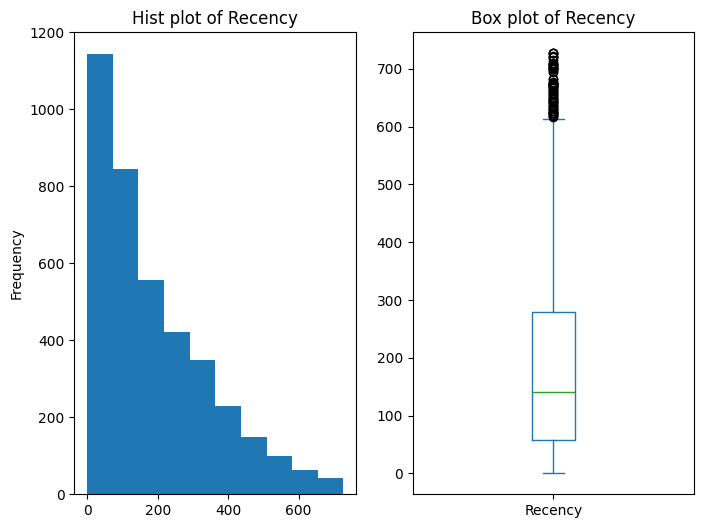

In [70]:
analyze_numeric_variable('Recency', df_rfm_pd)

=====
central tendency of Frequency: 
 {'mean': np.float64(3.8386351975371986), 'median': 4.0, 'mode': np.int64(3), 'min': 1, 'max': 11, 'range': 10}
=====
Dispersion of Frequency: 
 {'range': 10, 'q1': np.float64(2.0), 'q3': np.float64(5.0), 'iqr': np.float64(3.0), 'var': 3.5482426326022933, 'skew': np.float64(0.6422259721945635), 'kurtosis': np.float64(0.2352598432760682)}
=====


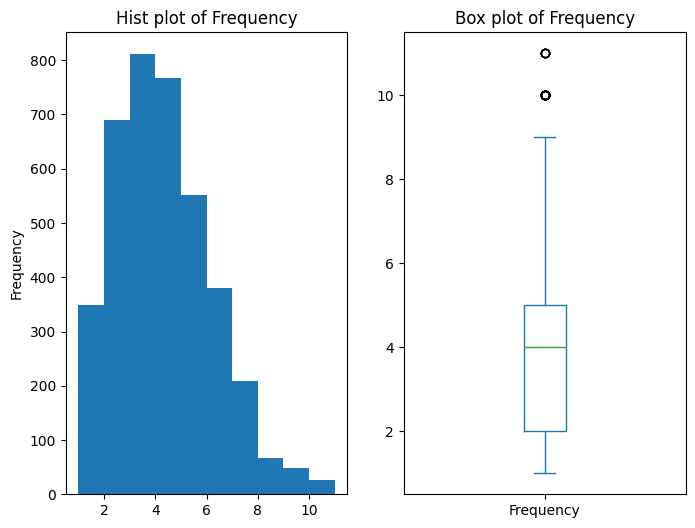

In [71]:
analyze_numeric_variable('Frequency', df_rfm_pd)

=====
central tendency of Monetary: 
 {'mean': np.float64(84.89733196511031), 'median': 74.755, 'mode': np.float64(57.5), 'min': 1.1, 'max': 361.45, 'range': 360.34999999999997}
=====
Dispersion of Monetary: 
 {'range': 360.34999999999997, 'q1': np.float64(43.57), 'q3': np.float64(114.975), 'iqr': np.float64(71.405), 'var': 3063.4005439190228, 'skew': np.float64(1.0281082998001159), 'kurtosis': np.float64(1.1561050791779546)}
=====


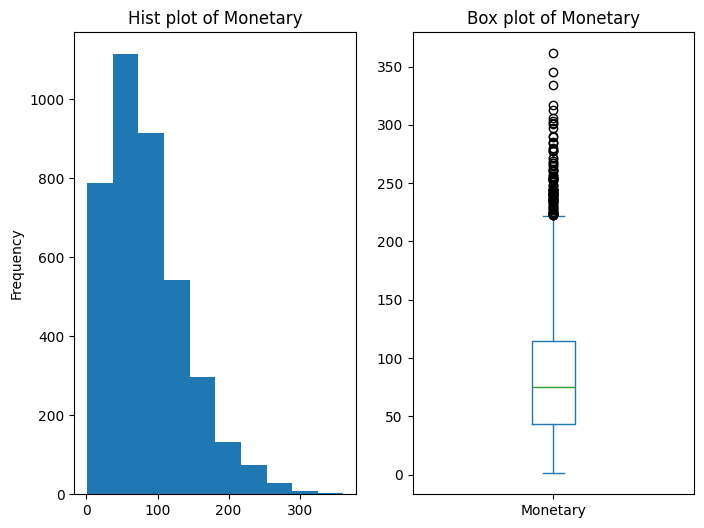

In [72]:
analyze_numeric_variable('Monetary', df_rfm_pd)

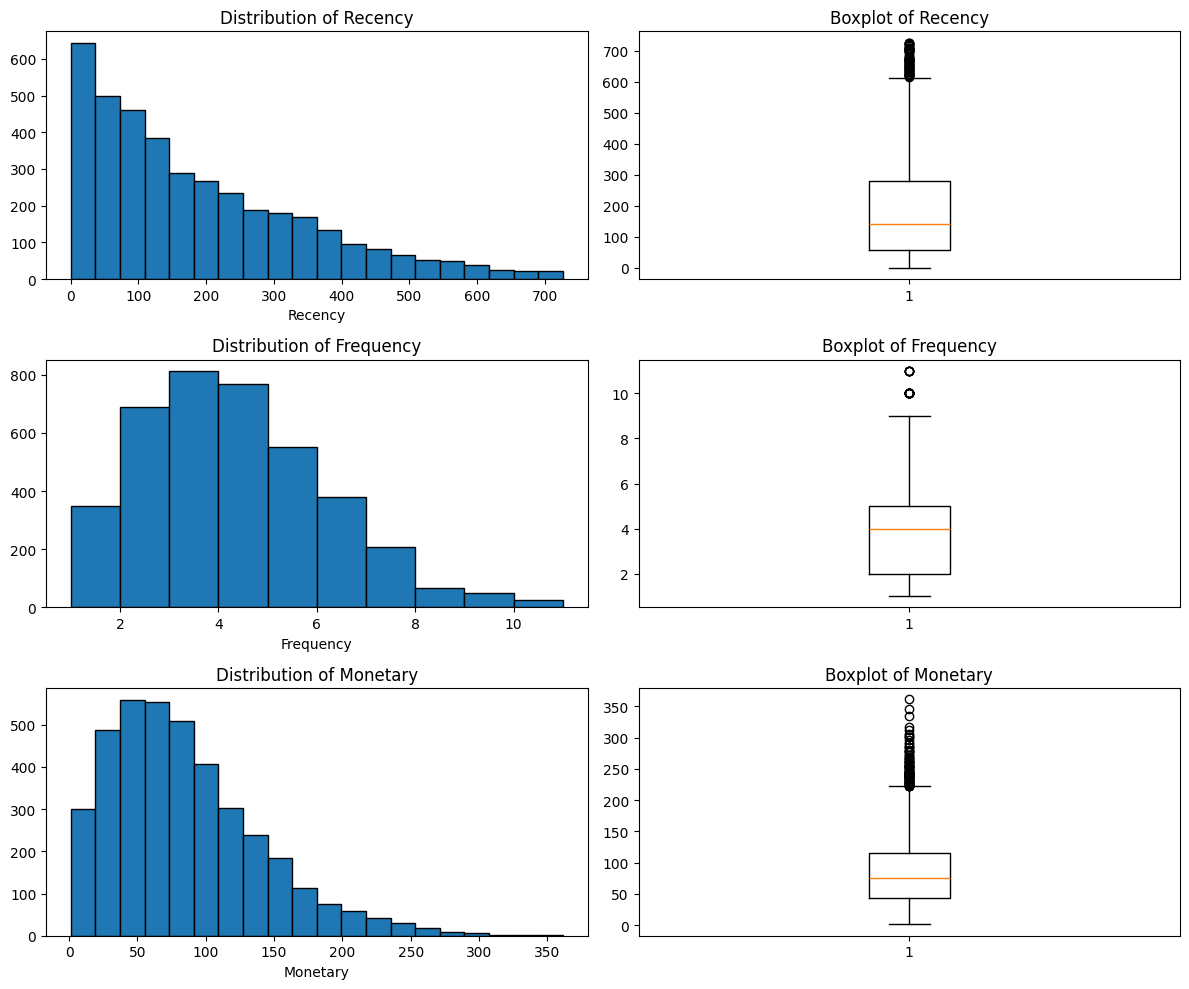

In [85]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Histogram
axs[0, 0].hist(df_rfm_pd['Recency'], bins=20, edgecolor='black')
axs[0, 0].set_title('Distribution of Recency')
axs[0, 0].set_xlabel('Recency')

axs[1, 0].hist(df_rfm_pd['Frequency'], bins=10, edgecolor='black')
axs[1, 0].set_title('Distribution of Frequency')
axs[1, 0].set_xlabel('Frequency')

axs[2, 0].hist(df_rfm_pd['Monetary'], bins=20, edgecolor='black')
axs[2, 0].set_title('Distribution of Monetary')
axs[2, 0].set_xlabel('Monetary')

# Boxplot
axs[0, 1].boxplot(df_rfm_pd['Recency'])
axs[0, 1].set_title('Boxplot of Recency')

axs[1, 1].boxplot(df_rfm_pd['Frequency'])
axs[1, 1].set_title('Boxplot of Frequency')

axs[2, 1].boxplot(df_rfm_pd['Monetary'])
axs[2, 1].set_title('Boxplot of Monetary')

plt.tight_layout()
plt.show()

In [73]:
from pyspark.sql.functions import percentile_approx


def find_outliers_iqr(df, column):
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df.filter((df[column] < lower_bound) | (df[column] > upper_bound))

    return outliers

In [74]:
outliers_recency = find_outliers_iqr(df_rfm, 'Recency')
outliers_recency.show(5)

+-------------+-------+---------+--------+
|Member_number|Recency|Frequency|Monetary|
+-------------+-------+---------+--------+
|         3444|    631|        2|  117.06|
|         2806|    633|        4|    98.5|
|         2137|    614|        2|    93.3|
|         1552|    720|        1|    80.1|
|         3149|    704|        1|    79.5|
+-------------+-------+---------+--------+
only showing top 5 rows



In [75]:
outliers_frequency = find_outliers_iqr(df_rfm, 'Frequency')
outliers_frequency.show(5)

+-------------+-------+---------+--------+
|Member_number|Recency|Frequency|Monetary|
+-------------+-------+---------+--------+
|         2193|     91|       11|  361.45|
|         1793|     26|       10|   345.1|
|         3289|      4|       10|  334.15|
|         3872|     37|       10|  301.33|
|         3593|     57|       10|   268.8|
+-------------+-------+---------+--------+
only showing top 5 rows



In [76]:
outliers_monetary = find_outliers_iqr(df_rfm, 'Monetary')
outliers_monetary.show(5)

+-------------+-------+---------+--------+
|Member_number|Recency|Frequency|Monetary|
+-------------+-------+---------+--------+
|         2193|     91|       11|  361.45|
|         1793|     26|       10|   345.1|
|         3289|      4|       10|  334.15|
|         2433|      3|        7|  316.81|
|         2743|    142|        7|  312.46|
+-------------+-------+---------+--------+
only showing top 5 rows



In [77]:
# Tính tỉ lệ phần trăm của Outliers trong bộ dữ liệu để xem xét trường hợp loại bỏ Outliers

def calculate_total_outliers_and_percentage(df, numerical_cols):
  no_outliers = 0
  outlier_percentages = {}
  total_count = df.count()

  for column in numerical_cols.columns:
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_count = df.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
    no_outliers += outlier_count
    outlier_percentage = (outlier_count / total_count) * 100
    outlier_percentages[column] = outlier_percentage

  return no_outliers, outlier_percentages

In [78]:
total_outliers, percentage_of_outliers = calculate_total_outliers_and_percentage(df_rfm, df_rfm.select('Recency', 'Frequency', 'Monetary'))
print(f'Total number of outliers is: {total_outliers}')

Total number of outliers is: 212


In [79]:
for column, percentage in percentage_of_outliers.items():
  print(f"Tỉ lệ phần trăm outliers trong cột '{column}': {percentage:.2f}%")

Tỉ lệ phần trăm outliers trong cột 'Recency': 1.95%
Tỉ lệ phần trăm outliers trong cột 'Frequency': 0.67%
Tỉ lệ phần trăm outliers trong cột 'Monetary': 2.82%


In [80]:
# Drop outliers (tỉ lệ outliers trong bộ dữ liệu khá nhỏ nên có thể drop)
def drop_outliers(df, numerical_cols):
  for column in numerical_cols.columns:
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

  return df

In [81]:
data_cleaned = drop_outliers(df_rfm, df_rfm.select('Recency', 'Frequency', 'Monetary'))
print(f'Kích thước DataFrame sau khi loại bỏ outliers: {data_cleaned.count()}')

Kích thước DataFrame sau khi loại bỏ outliers: 3663


In [87]:
data_cleaned_pd = data_cleaned.toPandas()
data_cleaned_pd.head(5)

,Member_number,Recency,Frequency,Monetary
0,3201,33,6,212.40
1,4235,11,7,211.84
2,3225,18,7,211.70
3,4666,28,6,210.57
4,2229,8,8,210.51


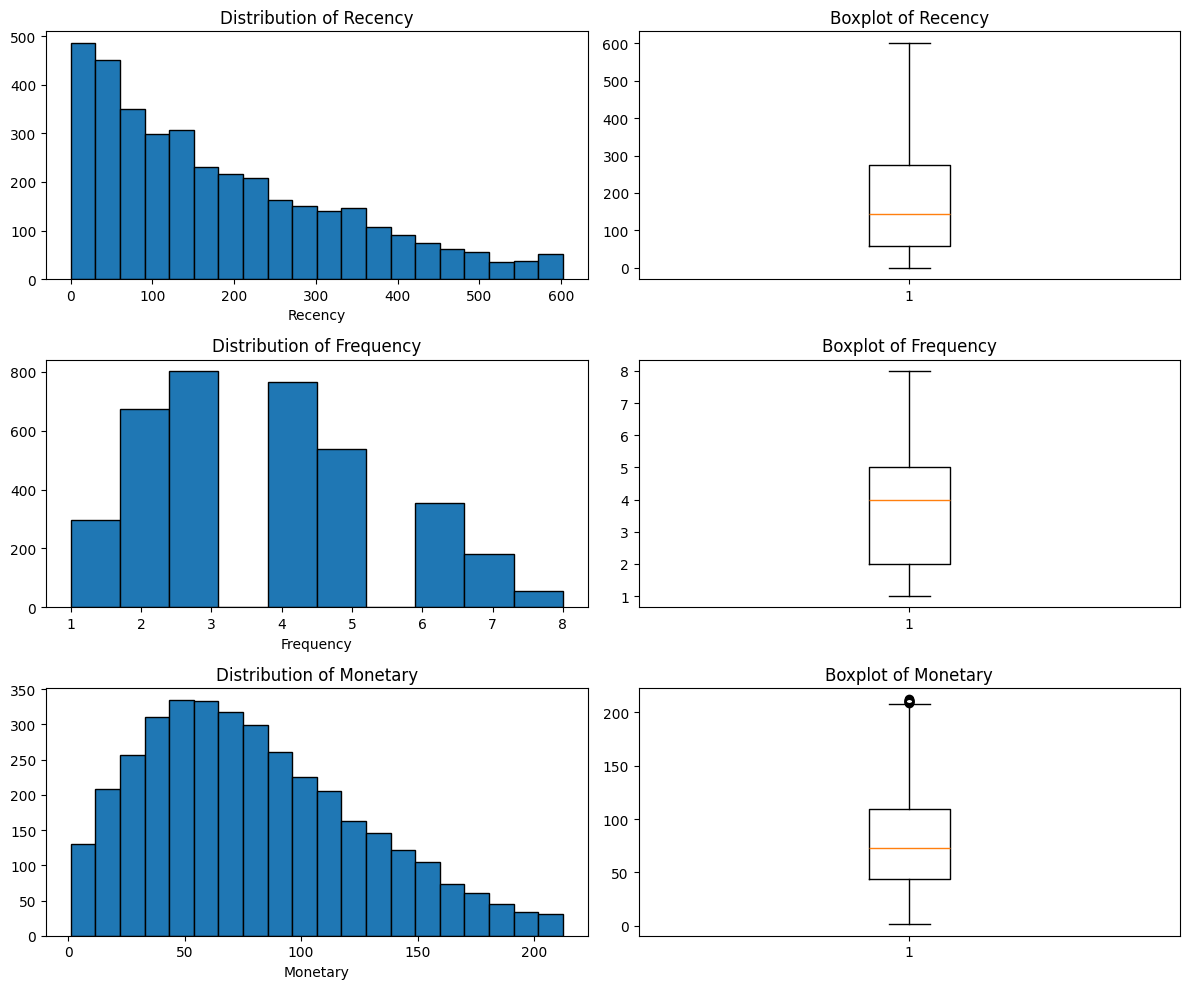

In [88]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Histogram
axs[0, 0].hist(data_cleaned_pd['Recency'], bins=20, edgecolor='black')
axs[0, 0].set_title('Distribution of Recency')
axs[0, 0].set_xlabel('Recency')

axs[1, 0].hist(data_cleaned_pd['Frequency'], bins=10, edgecolor='black')
axs[1, 0].set_title('Distribution of Frequency')
axs[1, 0].set_xlabel('Frequency')

axs[2, 0].hist(data_cleaned_pd['Monetary'], bins=20, edgecolor='black')
axs[2, 0].set_title('Distribution of Monetary')
axs[2, 0].set_xlabel('Monetary')

# Boxplot
axs[0, 1].boxplot(data_cleaned_pd['Recency'])
axs[0, 1].set_title('Boxplot of Recency')

axs[1, 1].boxplot(data_cleaned_pd['Frequency'])
axs[1, 1].set_title('Boxplot of Frequency')

axs[2, 1].boxplot(data_cleaned_pd['Monetary'])
axs[2, 1].set_title('Boxplot of Monetary')

plt.tight_layout()
plt.show()

### Scaling Data

#### Scaling Data with Outliers

In [ ]:
# pd.DataFrame.iteritems = pd.DataFrame.items

In [91]:
from pyspark.ml.feature import RobustScaler

# Assemble the features to be scaled
assembler = VectorAssembler(inputCols=['Recency', 'Frequency', 'Monetary'], outputCol='rfm_features')
assembled_data = assembler.transform(df_rfm)

# Initialize the RobustScaler
scaler = RobustScaler(inputCol='rfm_features', outputCol='rfm_features_scaled')

# Fit the scaler to the data
scaler_model = scaler.fit(assembled_data)

# Transform the data to apply scaling
scaled_data_robust = scaler_model.transform(assembled_data)

In [92]:
scaled_data_robust = scaled_data_robust.select('Member_number', 'Recency', 'Frequency', 'Monetary', 'rfm_features_scaled')
scaled_data_robust.show(5)

+-------------+-------+---------+--------+--------------------+
|Member_number|Recency|Frequency|Monetary| rfm_features_scaled|
+-------------+-------+---------+--------+--------------------+
|         2193|     91|       11|  361.45|[0.40807174887892...|
|         1793|     26|       10|   345.1|[0.11659192825112...|
|         3289|      4|       10|  334.15|[0.01793721973094...|
|         2433|      3|        7|  316.81|[0.01345291479820...|
|         2743|    142|        7|  312.46|[0.63677130044843...|
+-------------+-------+---------+--------+--------------------+
only showing top 5 rows



#### Scaling Data without Outliers

In [93]:
data_rfm_cleaned = data_cleaned.orderBy(col('Monetary').desc())
data_rfm_cleaned.show(5)

+-------------+-------+---------+--------+
|Member_number|Recency|Frequency|Monetary|
+-------------+-------+---------+--------+
|         3201|     33|        6|   212.4|
|         4235|     11|        7|  211.84|
|         3225|     18|        7|   211.7|
|         4666|     28|        6|  210.57|
|         2229|      8|        8|  210.51|
+-------------+-------+---------+--------+
only showing top 5 rows



In [94]:
from pyspark.ml.feature import StandardScaler

# Assemble the features to be scaled
assembler_wo = VectorAssembler(inputCols=['Recency', 'Frequency', 'Monetary'], outputCol='rfm_features_wo')
assembled_data_wo = assembler_wo.transform(data_rfm_cleaned)

# Initialize the RobustScaler
scaler_wo = StandardScaler(inputCol='rfm_features_wo', outputCol='rfm_features_scaled_wo', withStd=True, withMean=True)

# Fit the scaler to the data
scaler_model_wo = scaler_wo.fit(assembled_data_wo)

# Transform the data to apply scaling
scaled_data_standard_wo = scaler_model_wo.transform(assembled_data_wo)

In [95]:
scaled_data_standard_wo = scaled_data_standard_wo.select('Member_number', 'Recency', 'Frequency', 'Monetary', 'rfm_features_scaled_wo')
scaled_data_standard_wo.show(5)

+-------------+-------+---------+--------+----------------------+
|Member_number|Recency|Frequency|Monetary|rfm_features_scaled_wo|
+-------------+-------+---------+--------+----------------------+
|         3201|     33|        6|   212.4|  [-1.0104457934050...|
|         4235|     11|        7|  211.84|  [-1.1594905752449...|
|         3225|     18|        7|   211.7|  [-1.1120672355685...|
|         4666|     28|        6|  210.57|  [-1.0443196074595...|
|         2229|      8|        8|  210.51|  [-1.1798148636776...|
+-------------+-------+---------+--------+----------------------+
only showing top 5 rows



## Building Models

### RFM + KMeans (with outliers and no scaling data)

In [96]:
df_kmeans = df_rfm.select('Recency', 'Frequency', 'Monetary')
df_kmeans.show(5)

+-------+---------+--------+
|Recency|Frequency|Monetary|
+-------+---------+--------+
|     91|       11|  361.45|
|     26|       10|   345.1|
|      4|       10|  334.15|
|      3|        7|  316.81|
|    142|        7|  312.46|
+-------+---------+--------+
only showing top 5 rows



In [97]:
df_kmeans.describe().show(5)

+-------+------------------+------------------+-----------------+
|summary|           Recency|         Frequency|         Monetary|
+-------+------------------+------------------+-----------------+
|  count|              3898|              3898|             3898|
|   mean| 187.7013853258081|3.8386351975371986|84.89733196511037|
| stddev|159.91268820914235|1.8836779535266222|55.34799494036805|
|    min|                 0|                 1|              1.1|
|    max|               727|                11|           361.45|
+-------+------------------+------------------+-----------------+



In [98]:
vec_assembler = VectorAssembler(inputCols=df_kmeans.columns,
                                outputCol='features')

In [99]:
df_kmeans_vectorized = vec_assembler.transform(df_kmeans).select('features')
df_kmeans_vectorized.show(5)

+------------------+
|          features|
+------------------+
|[91.0,11.0,361.45]|
| [26.0,10.0,345.1]|
| [4.0,10.0,334.15]|
|  [3.0,7.0,316.81]|
|[142.0,7.0,312.46]|
+------------------+
only showing top 5 rows



In [100]:
original_data = vec_assembler.transform(df_kmeans)
original_data.show(5)

+-------+---------+--------+------------------+
|Recency|Frequency|Monetary|          features|
+-------+---------+--------+------------------+
|     91|       11|  361.45|[91.0,11.0,361.45]|
|     26|       10|   345.1| [26.0,10.0,345.1]|
|      4|       10|  334.15| [4.0,10.0,334.15]|
|      3|        7|  316.81|  [3.0,7.0,316.81]|
|    142|        7|  312.46|[142.0,7.0,312.46]|
+-------+---------+--------+------------------+
only showing top 5 rows



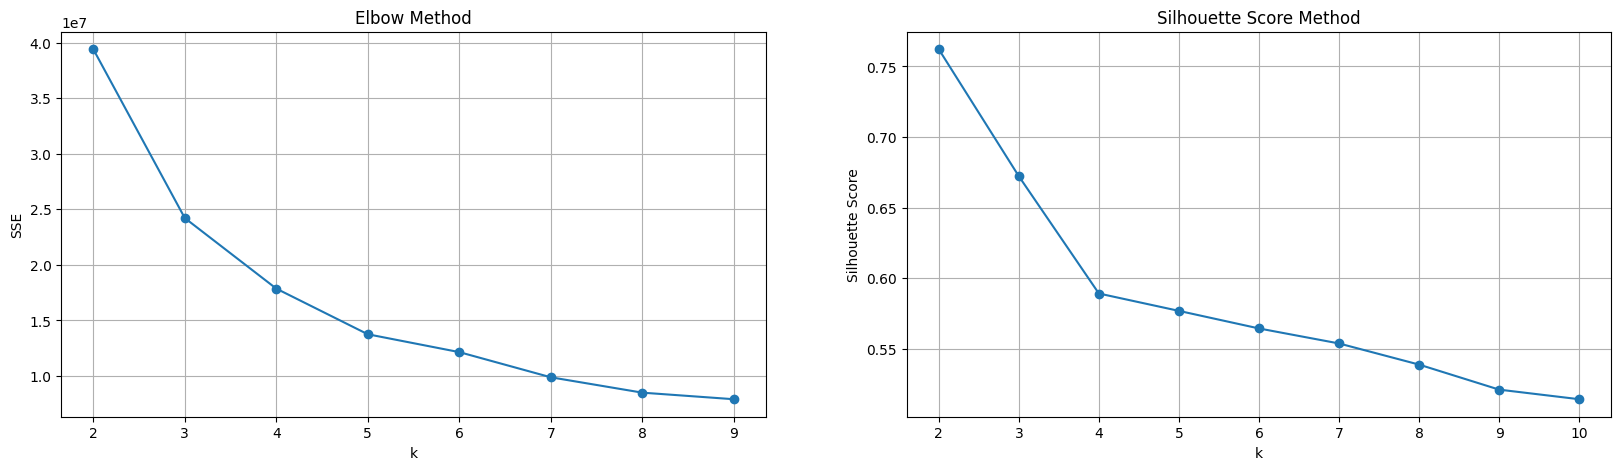

In [102]:
# Initialize empty lists for SSE and Silhouette Score
sse = {}
sil = []
kmax = 10
sil_str = ""

# Elbow Method: Compute SSE for different k-values
for k in range(2, kmax):
    kmeans = KMeans(k=k, seed=42, featuresCol='features', predictionCol='cluster')
    model = kmeans.fit(df_kmeans_vectorized)
    sse[k] = model.summary.trainingCost  # SSE (inertia in sklearn)

# Silhouette Score Method
for k in range(2, kmax + 1):  # Silhouette Score is only valid for k ≥ 2
    kmeans = KMeans(k=k, seed=42, featuresCol='features', predictionCol='cluster')
    model = kmeans.fit(df_kmeans_vectorized)
    predictions = model.transform(df_kmeans_vectorized)

    evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='cluster', metricName='silhouette')
    sil_score = evaluator.evaluate(predictions)
    sil.append(sil_score)

    sil_str = sil_str + 'With k = ' + str(k) + " - Silhouette = " + str(sil_score) + '\n'

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Elbow Method Plot
ax[0].plot(list(sse.keys()), list(sse.values()), marker='o')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('k')
ax[0].set_ylabel('SSE')
ax[0].grid()

# Silhouette Score Plot
ax[1].plot(range(2, kmax + 1), sil, marker='o')
ax[1].set_title('Silhouette Score Method')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid()

plt.show()

In [103]:
print(sil_str)

With k = 2 - Silhouette = 0.7622211690429646
With k = 3 - Silhouette = 0.6721893744739528
With k = 4 - Silhouette = 0.5890499983266997
With k = 5 - Silhouette = 0.5767296173640032
With k = 6 - Silhouette = 0.5642733355242112
With k = 7 - Silhouette = 0.5536335389369688
With k = 8 - Silhouette = 0.5386443346968668
With k = 9 - Silhouette = 0.5209016912089349
With k = 10 - Silhouette = 0.5141078372578922



In [104]:
df_kmeans_vec = vec_assembler.transform(df_rfm).select('Member_number', 'Recency', 'Frequency', 'Monetary', 'features')
df_kmeans_vec.show(5)

+-------------+-------+---------+--------+------------------+
|Member_number|Recency|Frequency|Monetary|          features|
+-------------+-------+---------+--------+------------------+
|         2193|     91|       11|  361.45|[91.0,11.0,361.45]|
|         1793|     26|       10|   345.1| [26.0,10.0,345.1]|
|         3289|      4|       10|  334.15| [4.0,10.0,334.15]|
|         2433|      3|        7|  316.81|  [3.0,7.0,316.81]|
|         2743|    142|        7|  312.46|[142.0,7.0,312.46]|
+-------------+-------+---------+--------+------------------+
only showing top 5 rows



#### With k=6

In [105]:
# Train K-Means with k=6
kmeans_1 = KMeans(k=6, seed=42, featuresCol='features', predictionCol='cluster')
model_1 = kmeans_1.fit(df_kmeans_vec)

# Get cluster labels
df_clusters_1 = model_1.transform(df_kmeans_vec).select('Member_number', 'Recency', 'Frequency', 'Monetary', 'cluster')

# Show cluster assignments
df_clusters_1.show(5)

+-------------+-------+---------+--------+-------+
|Member_number|Recency|Frequency|Monetary|cluster|
+-------------+-------+---------+--------+-------+
|         2193|     91|       11|  361.45|      1|
|         1793|     26|       10|   345.1|      1|
|         3289|      4|       10|  334.15|      1|
|         2433|      3|        7|  316.81|      1|
|         2743|    142|        7|  312.46|      1|
+-------------+-------+---------+--------+-------+
only showing top 5 rows



In [106]:
labels_1 = df_clusters_1.count()
print('Number of cluster assignments:', labels_1)

Number of cluster assignments: 3898


In [107]:
# Perform aggregations (mean & count)
df_cluster_summary_1 = df_clusters_1.groupBy('cluster').agg(mean('Recency').alias('Avg_Recency'),
                                                            mean('Frequency').alias('Avg_Frequency'),
                                                            mean('Monetary').alias('Avg_Monetary'), count('Member_number').alias('Count'))

# Show the result
df_cluster_summary_1.show()

+-------+------------------+------------------+------------------+-----+
|cluster|       Avg_Recency|     Avg_Frequency|      Avg_Monetary|Count|
+-------+------------------+------------------+------------------+-----+
|      1| 49.27788279773157| 6.126654064272212|174.57134215500952|  529|
|      3|348.98581560283685|2.9574468085106385|61.154524822695016|  705|
|      5|           55.6875| 3.831925675675676|   71.348133445946| 1184|
|      4|             181.4| 5.342105263157895|144.64178947368427|  380|
|      2| 554.3930817610063|1.9654088050314464| 37.94053459119494|  318|
|      0| 189.7621483375959| 3.126598465473146|  56.2179795396419|  782|
+-------+------------------+------------------+------------------+-----+



In [108]:
# Compute Aggregates for Each Cluster
rfm_agg_1 = df_clusters_1.groupBy('Cluster').agg(round(mean('Recency'), 0).alias('RecencyMean'),
                                                 round(mean('Frequency'), 0).alias('FrequencyMean'),
                                                 round(mean('Monetary'), 0).alias('MonetaryMean'),
                                                 count('*').alias('Count'))

# Compute Percentage of Each Cluster
total_count = df_clusters_1.count()
rfm_agg_1 = rfm_agg_1.withColumn('Percent', round((rfm_agg_1['Count'] / total_count) * 100, 2))

# Convert Cluster Labels to "Cluster X" Format
rfm_agg_1 = rfm_agg_1.withColumn('Cluster', concat(lit('Cluster '), rfm_agg_1['Cluster'].cast('string')))

# Show the Result
rfm_agg_1.show()

+---------+-----------+-------------+------------+-----+-------+
|  Cluster|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+---------+-----------+-------------+------------+-----+-------+
|Cluster 1|       49.0|          6.0|       175.0|  529|  13.57|
|Cluster 3|      349.0|          3.0|        61.0|  705|  18.09|
|Cluster 5|       56.0|          4.0|        71.0| 1184|  30.37|
|Cluster 4|      181.0|          5.0|       145.0|  380|   9.75|
|Cluster 2|      554.0|          2.0|        38.0|  318|   8.16|
|Cluster 0|      190.0|          3.0|        56.0|  782|  20.06|
+---------+-----------+-------------+------------+-----+-------+



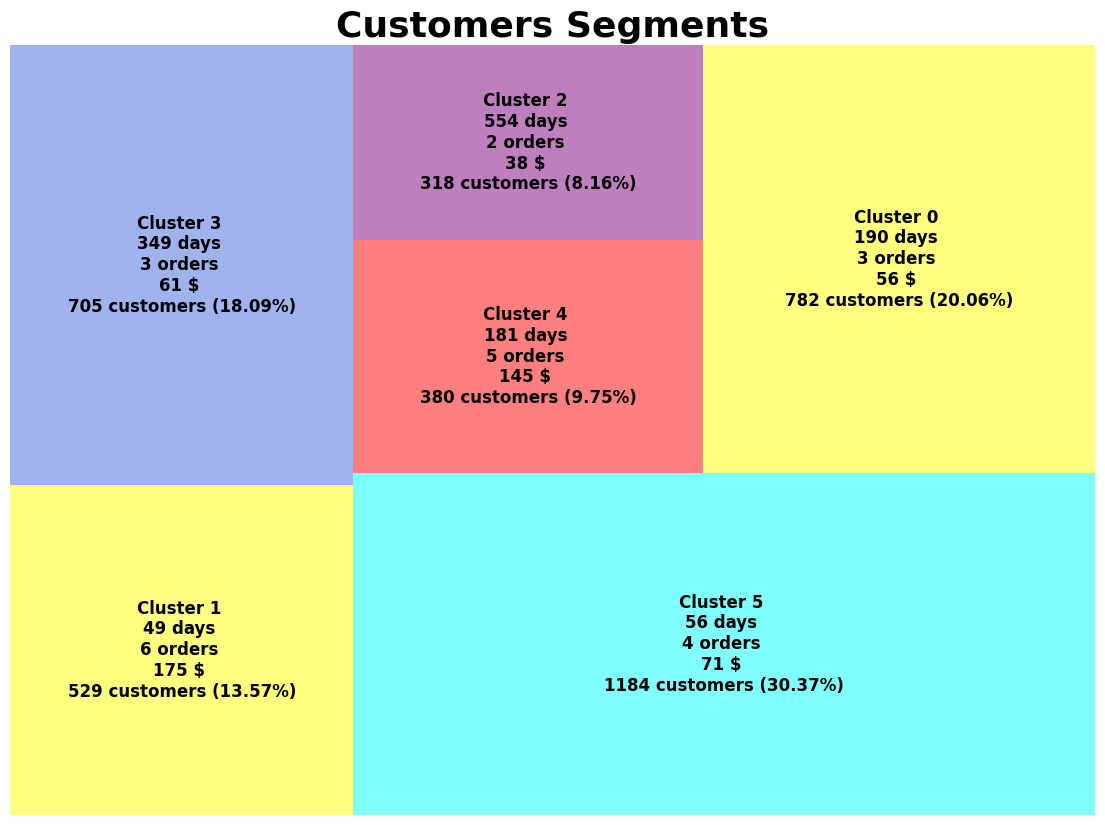

In [109]:
# Treemap

# Convert PySpark DataFrame to Pandas for Visualization
rfm_agg_1_pd = rfm_agg_1.toPandas()

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict1 = {'Cluster0': 'yellow', 'Cluster1': 'royalblue', 'Cluster2': 'cyan', 'Cluster3': 'red', 'Cluster4': 'purple'}

squarify.plot(sizes=rfm_agg_1_pd['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict1.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_1_pd.iloc[i])
                      for i in range(0, len(rfm_agg_1_pd))], alpha=0.5)


plt.title('Customers Segments', fontsize=26, fontweight='bold')
plt.axis('off')
plt.show()

In [110]:
# Create Scatter Plot
fig = px.scatter(rfm_agg_1_pd, x='RecencyMean', y='MonetaryMean', size='FrequencyMean', color='Cluster', hover_name='Cluster', size_max=100)
fig.show()

#### With k=5

In [111]:
# Train K-Means with k=5
kmeans_2 = KMeans(k=5, seed=42, featuresCol='features', predictionCol='cluster')
model_2 = kmeans_2.fit(df_kmeans_vec)

# Get cluster labels
df_clusters_2 = model_2.transform(df_kmeans_vec).select('Member_number', 'Recency', 'Frequency', 'Monetary', 'cluster')

# Show cluster assignments
df_clusters_2.show(5)

+-------------+-------+---------+--------+-------+
|Member_number|Recency|Frequency|Monetary|cluster|
+-------------+-------+---------+--------+-------+
|         2193|     91|       11|  361.45|      4|
|         1793|     26|       10|   345.1|      4|
|         3289|      4|       10|  334.15|      4|
|         2433|      3|        7|  316.81|      4|
|         2743|    142|        7|  312.46|      4|
+-------------+-------+---------+--------+-------+
only showing top 5 rows



In [112]:
labels_2 = df_clusters_2.count()
print('Number of cluster assignments:', labels_2)

Number of cluster assignments: 3898


In [113]:
# Perform aggregations (mean & count)
df_cluster_summary_2 = df_clusters_2.groupBy('cluster').agg(mean('Recency').alias('Avg_Recency'),
                                                            mean('Frequency').alias('Avg_Frequency'),
                                                            mean('Monetary').alias('Avg_Monetary'), count('Member_number').alias('Count'))

# Show the result
df_cluster_summary_2.show()

+-------+------------------+------------------+------------------+-----+
|cluster|       Avg_Recency|     Avg_Frequency|      Avg_Monetary|Count|
+-------+------------------+------------------+------------------+-----+
|      1| 54.26739312657167|3.8256496227996646| 71.56953897736805| 1193|
|      3|343.79047619047617|2.9891156462585036| 63.12183673469385|  735|
|      4| 63.72147651006711|6.1644295302013425|175.94689597315434|  596|
|      2| 551.4556574923547|1.9847094801223242| 37.84694189602443|  327|
|      0|187.13371537726837|3.7048710601719197| 78.23542502387762| 1047|
+-------+------------------+------------------+------------------+-----+



In [114]:
# Compute Aggregates for Each Cluster
rfm_agg_2 = df_clusters_2.groupBy('Cluster').agg(round(mean('Recency'), 0).alias('RecencyMean'),
                                                 round(mean('Frequency'), 0).alias('FrequencyMean'),
                                                 round(mean('Monetary'), 0).alias('MonetaryMean'),
                                                 count('*').alias('Count'))

# Compute Percentage of Each Cluster
total_count = df_clusters_2.count()
rfm_agg_2 = rfm_agg_2.withColumn('Percent', round((rfm_agg_2['Count'] / total_count) * 100, 2))

# Convert Cluster Labels to "Cluster X" Format
rfm_agg_2 = rfm_agg_2.withColumn('Cluster', concat(lit('Cluster '), rfm_agg_2['Cluster'].cast('string')))

# Show the Result
rfm_agg_2.show()

+---------+-----------+-------------+------------+-----+-------+
|  Cluster|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+---------+-----------+-------------+------------+-----+-------+
|Cluster 1|       54.0|          4.0|        72.0| 1193|  30.61|
|Cluster 3|      344.0|          3.0|        63.0|  735|  18.86|
|Cluster 4|       64.0|          6.0|       176.0|  596|  15.29|
|Cluster 2|      551.0|          2.0|        38.0|  327|   8.39|
|Cluster 0|      187.0|          4.0|        78.0| 1047|  26.86|
+---------+-----------+-------------+------------+-----+-------+



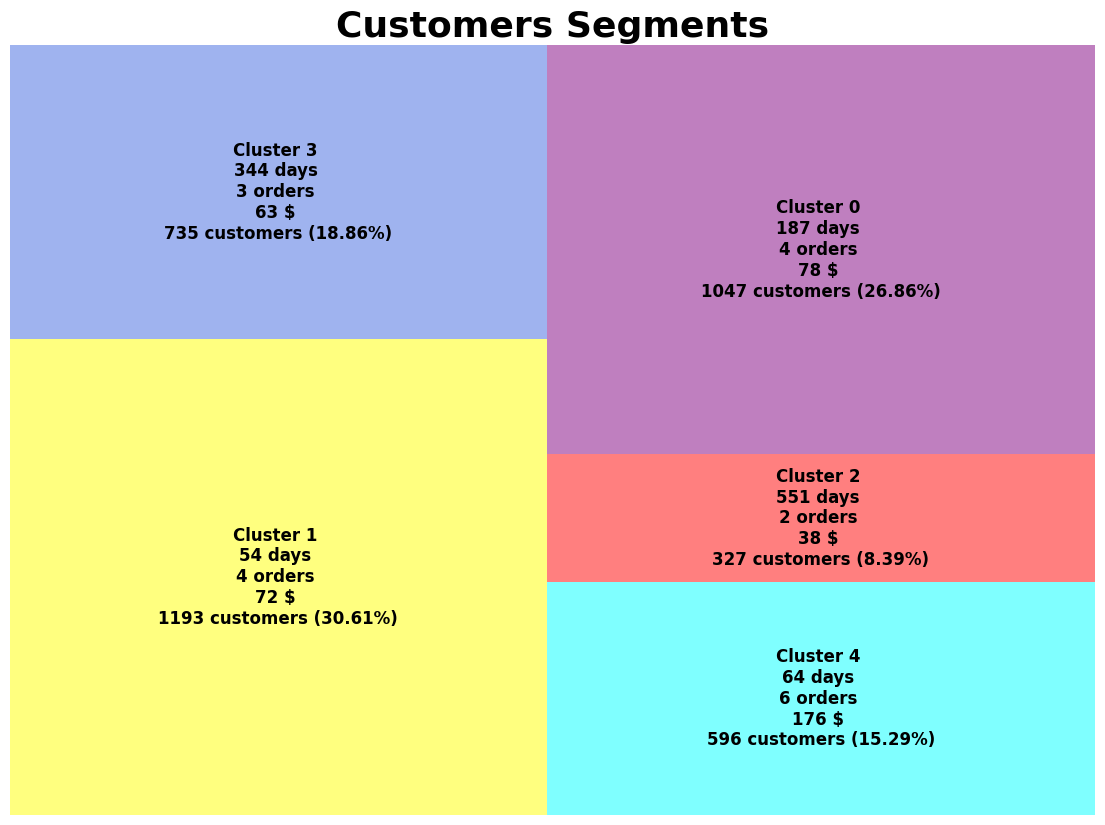

In [115]:
# Treemap

# Convert PySpark DataFrame to Pandas for Visualization
rfm_agg_2_pd = rfm_agg_2.toPandas()

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple'}

squarify.plot(sizes=rfm_agg_2_pd['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_2_pd.iloc[i])
                      for i in range(0, len(rfm_agg_2_pd))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [116]:
# Create Scatter Plot
fig = px.scatter(rfm_agg_2_pd, x='RecencyMean', y='MonetaryMean', size='FrequencyMean', color='Cluster', hover_name='Cluster', size_max=100)
fig.show()

### RFM + KMeans (with outliers and scaling data)

In [ ]:
df_kmeans_vec_scaled = scaled_data_robust.select('Member_number', 'Recency', 'Frequency', 'Monetary', 'rfm_features_scaled')
df_kmeans_vec_scaled.show(5)

+-------------+-------+---------+--------+--------------------+
|Member_number|Recency|Frequency|Monetary| rfm_features_scaled|
+-------------+-------+---------+--------+--------------------+
|         2193|     91|       11|  361.45|[0.40807174887892...|
|         1793|     26|       10|   345.1|[0.11659192825112...|
|         3289|      4|       10|  334.15|[0.01793721973094...|
|         2433|      3|        7|  316.81|[0.01345291479820...|
|         2743|    142|        7|  312.46|[0.63677130044843...|
+-------------+-------+---------+--------+--------------------+
only showing top 5 rows



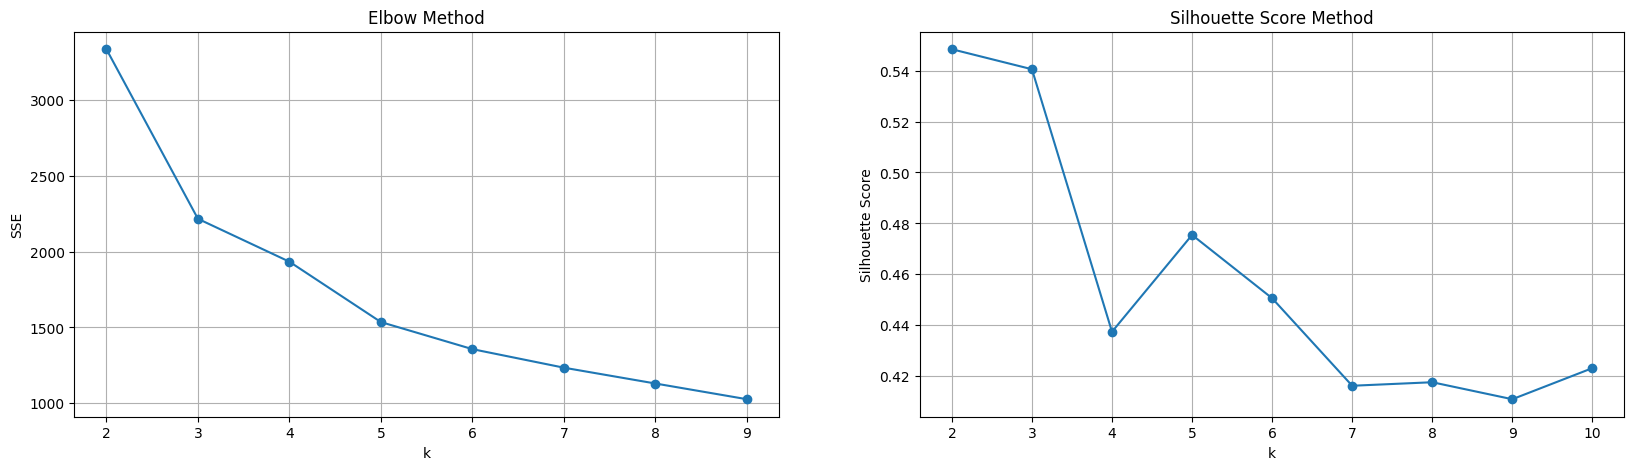

In [ ]:
# Initialize empty lists for SSE and Silhouette Score
sse = {}
sil = []
kmax = 10
sil_str = ""

# Elbow Method: Compute SSE for different k-values
for k in range(2, kmax):
    kmeans = KMeans(k=k, seed=42, featuresCol='rfm_features_scaled', predictionCol='cluster')
    model = kmeans.fit(df_kmeans_vec_scaled)
    sse[k] = model.summary.trainingCost  # SSE (inertia in sklearn)

# Silhouette Score Method
for k in range(2, kmax + 1):  # Silhouette Score is only valid for k ≥ 2
    kmeans = KMeans(k=k, seed=42, featuresCol='rfm_features_scaled', predictionCol='cluster')
    model = kmeans.fit(df_kmeans_vec_scaled)
    predictions = model.transform(df_kmeans_vec_scaled)

    evaluator = ClusteringEvaluator(featuresCol='rfm_features_scaled', predictionCol='cluster', metricName='silhouette')
    sil_score = evaluator.evaluate(predictions)
    sil.append(sil_score)

    sil_str = sil_str + 'With k = ' + str(k) + " - Silhouette = " + str(sil_score) + '\n'

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Elbow Method Plot
ax[0].plot(list(sse.keys()), list(sse.values()), marker='o')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('k')
ax[0].set_ylabel('SSE')
ax[0].grid()

# Silhouette Score Plot
ax[1].plot(range(2, kmax + 1), sil, marker='o')
ax[1].set_title('Silhouette Score Method')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid()

plt.show()

In [ ]:
print(sil_str)

With k = 2 - Silhouette = 0.5484168358335835
With k = 3 - Silhouette = 0.5405535031622399
With k = 4 - Silhouette = 0.4374381850409717
With k = 5 - Silhouette = 0.4754665113967905
With k = 6 - Silhouette = 0.45060663677108154
With k = 7 - Silhouette = 0.41623317269884025
With k = 8 - Silhouette = 0.41761402342309933
With k = 9 - Silhouette = 0.41094343240230236
With k = 10 - Silhouette = 0.4231566909582561



#### With k=6

In [ ]:
# Train K-Means with k=6
kmeans_3 = KMeans(k=6, seed=42, featuresCol='rfm_features_scaled', predictionCol='cluster')
model_3 = kmeans_3.fit(df_kmeans_vec_scaled)

# Get cluster labels
df_clusters_3 = model_3.transform(df_kmeans_vec_scaled).select('Member_number', 'Recency', 'Frequency', 'Monetary', 'cluster')

# Show cluster assignments
df_clusters_3.show(5)

+-------------+-------+---------+--------+-------+
|Member_number|Recency|Frequency|Monetary|cluster|
+-------------+-------+---------+--------+-------+
|         2193|     91|       11|  361.45|      0|
|         1793|     26|       10|   345.1|      0|
|         3289|      4|       10|  334.15|      0|
|         2433|      3|        7|  316.81|      0|
|         2743|    142|        7|  312.46|      0|
+-------------+-------+---------+--------+-------+
only showing top 5 rows



In [ ]:
labels_3 = df_clusters_3.count()
print('Number of cluster assignments:', labels_3)

Number of cluster assignments: 3898


In [ ]:
# Perform aggregations (mean & count)
df_cluster_summary_3 = df_clusters_3.groupBy('cluster').agg(mean('Recency').alias('Avg_Recency'),
                                                            mean('Frequency').alias('Avg_Frequency'),
                                                            mean('Monetary').alias('Avg_Monetary'), count('Member_number').alias('Count'))

# Show the result
df_cluster_summary_3.show()

+-------+------------------+------------------+------------------+-----+
|cluster|       Avg_Recency|     Avg_Frequency|      Avg_Monetary|Count|
+-------+------------------+------------------+------------------+-----+
|      1|279.29477611940297|  4.28544776119403| 100.2536380597015|  536|
|      3| 91.12449799196787| 2.860441767068273| 51.71675702811234|  996|
|      5| 72.88354700854701|5.0256410256410255|108.82217948717951|  936|
|      4|302.94372990353696| 2.239549839228296|39.615176848874626|  622|
|      2| 538.1353591160221|1.8701657458563536| 34.85580110497234|  362|
|      0| 89.10986547085201| 6.822869955156951|194.09856502242167|  446|
+-------+------------------+------------------+------------------+-----+



In [ ]:
# Compute Aggregates for Each Cluster
rfm_agg_3 = df_clusters_3.groupBy('Cluster').agg(round(mean('Recency'), 0).alias('RecencyMean'),
                                                 round(mean('Frequency'), 0).alias('FrequencyMean'),
                                                 round(mean('Monetary'), 0).alias('MonetaryMean'),
                                                 count('*').alias('Count'))

# Compute Percentage of Each Cluster
total_count = df_clusters_3.count()
rfm_agg_3 = rfm_agg_3.withColumn('Percent', round((rfm_agg_3['Count'] / total_count) * 100, 2))

# Convert Cluster Labels to "Cluster X" Format
rfm_agg_3 = rfm_agg_3.withColumn('Cluster', concat(lit('Cluster '), rfm_agg_3['Cluster'].cast('string')))

# Show the Result
rfm_agg_3.show()

+---------+-----------+-------------+------------+-----+-------+
|  Cluster|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+---------+-----------+-------------+------------+-----+-------+
|Cluster 1|      279.0|          4.0|       100.0|  536|  13.75|
|Cluster 3|       91.0|          3.0|        52.0|  996|  25.55|
|Cluster 5|       73.0|          5.0|       109.0|  936|  24.01|
|Cluster 4|      303.0|          2.0|        40.0|  622|  15.96|
|Cluster 2|      538.0|          2.0|        35.0|  362|   9.29|
|Cluster 0|       89.0|          7.0|       194.0|  446|  11.44|
+---------+-----------+-------------+------------+-----+-------+



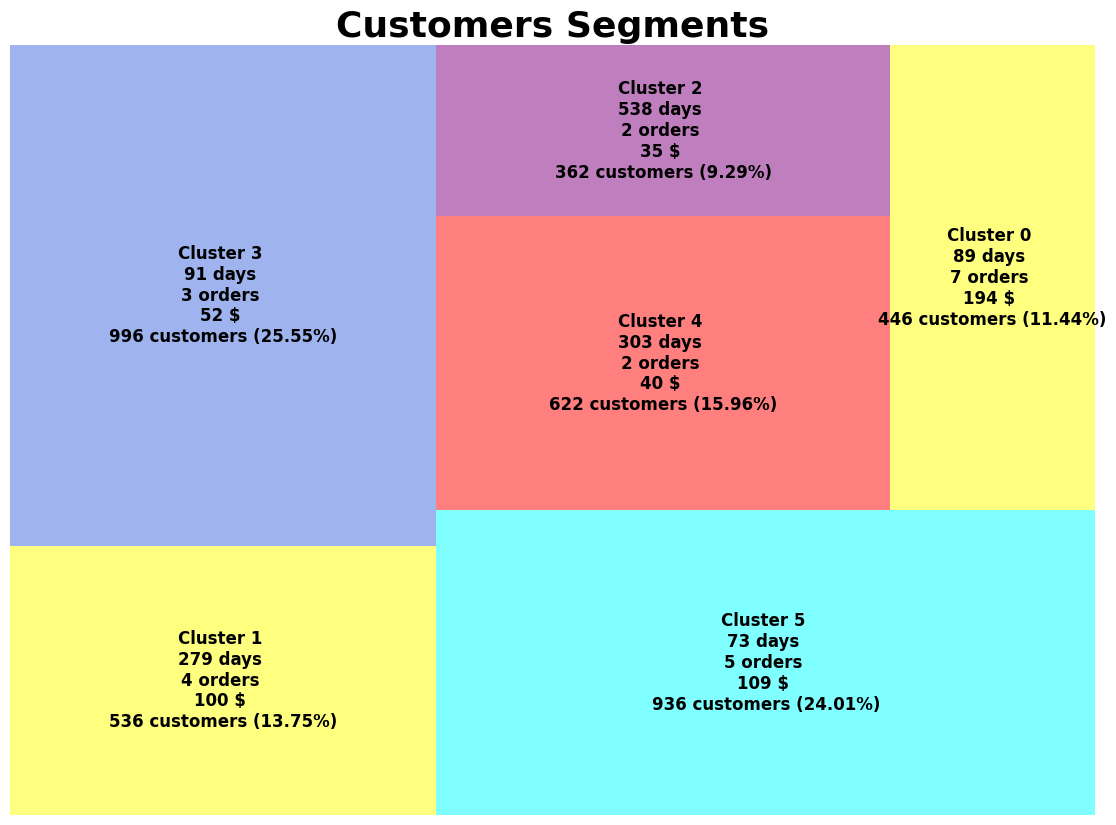

In [ ]:
# Treemap

# Convert PySpark DataFrame to Pandas for Visualization
rfm_agg_3_pd = rfm_agg_3.toPandas()

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict3 = {'Cluster0': 'yellow', 'Cluster1': 'royalblue', 'Cluster2': 'cyan', 'Cluster3': 'red', 'Cluster4': 'purple'}

squarify.plot(sizes=rfm_agg_3_pd['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict3.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_3_pd.iloc[i])
                      for i in range(0, len(rfm_agg_3_pd))], alpha=0.5)


plt.title('Customers Segments', fontsize=26, fontweight='bold')
plt.axis('off')
plt.show()

In [ ]:
# Create Scatter Plot
fig = px.scatter(rfm_agg_3_pd, x='RecencyMean', y='MonetaryMean', size='FrequencyMean', color='Cluster', hover_name='Cluster', size_max=100)
fig.show()

#### With k=5

In [ ]:
# Train K-Means with k=5
kmeans_4 = KMeans(k=5, seed=42, featuresCol='rfm_features_scaled', predictionCol='cluster')
model_4 = kmeans_4.fit(df_kmeans_vec_scaled)

# Get cluster labels
df_clusters_4 = model_4.transform(df_kmeans_vec_scaled).select('Member_number', 'Recency', 'Frequency', 'Monetary', 'cluster')

# Show cluster assignments
df_clusters_4.show(5)

+-------------+-------+---------+--------+-------+
|Member_number|Recency|Frequency|Monetary|cluster|
+-------------+-------+---------+--------+-------+
|         2193|     91|       11|  361.45|      0|
|         1793|     26|       10|   345.1|      0|
|         3289|      4|       10|  334.15|      0|
|         2433|      3|        7|  316.81|      0|
|         2743|    142|        7|  312.46|      0|
+-------------+-------+---------+--------+-------+
only showing top 5 rows



In [ ]:
labels_4 = df_clusters_4.count()
print('Number of cluster assignments:', labels_4)

Number of cluster assignments: 3898


In [ ]:
# Perform aggregations (mean & count)
df_cluster_summary_4 = df_clusters_4.groupBy('cluster').agg(mean('Recency').alias('Avg_Recency'),
                                                            mean('Frequency').alias('Avg_Frequency'),
                                                            mean('Monetary').alias('Avg_Monetary'), count('Member_number').alias('Count'))

# Show the result
df_cluster_summary_4.show()

+-------+------------------+------------------+------------------+-----+
|cluster|       Avg_Recency|     Avg_Frequency|      Avg_Monetary|Count|
+-------+------------------+------------------+------------------+-----+
|      1| 89.56057866184449| 4.939421338155515|107.83953887884267| 1106|
|      3| 110.3482224247949|2.6736554238833183| 46.99611668185949| 1097|
|      4|308.51769911504425| 3.579646017699115| 79.71233038348073|  678|
|      2| 469.8965517241379|1.7731397459165155|29.829165154264977|  551|
|      0| 93.27467811158799|  6.78755364806867|192.32553648068688|  466|
+-------+------------------+------------------+------------------+-----+



In [ ]:
# Compute Aggregates for Each Cluster
rfm_agg_4 = df_clusters_4.groupBy('Cluster').agg(round(mean('Recency'), 0).alias('RecencyMean'),
                                                 round(mean('Frequency'), 0).alias('FrequencyMean'),
                                                 round(mean('Monetary'), 0).alias('MonetaryMean'),
                                                 count('*').alias('Count'))

# Compute Percentage of Each Cluster
total_count = df_clusters_4.count()
rfm_agg_4 = rfm_agg_4.withColumn('Percent', round((rfm_agg_4['Count'] / total_count) * 100, 2))

# Convert Cluster Labels to "Cluster X" Format
rfm_agg_4 = rfm_agg_4.withColumn('Cluster', concat(lit('Cluster '), rfm_agg_4['Cluster'].cast('string')))

# Show the Result
rfm_agg_4.show()

+---------+-----------+-------------+------------+-----+-------+
|  Cluster|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+---------+-----------+-------------+------------+-----+-------+
|Cluster 1|       90.0|          5.0|       108.0| 1106|  28.37|
|Cluster 3|      110.0|          3.0|        47.0| 1097|  28.14|
|Cluster 4|      309.0|          4.0|        80.0|  678|  17.39|
|Cluster 2|      470.0|          2.0|        30.0|  551|  14.14|
|Cluster 0|       93.0|          7.0|       192.0|  466|  11.95|
+---------+-----------+-------------+------------+-----+-------+



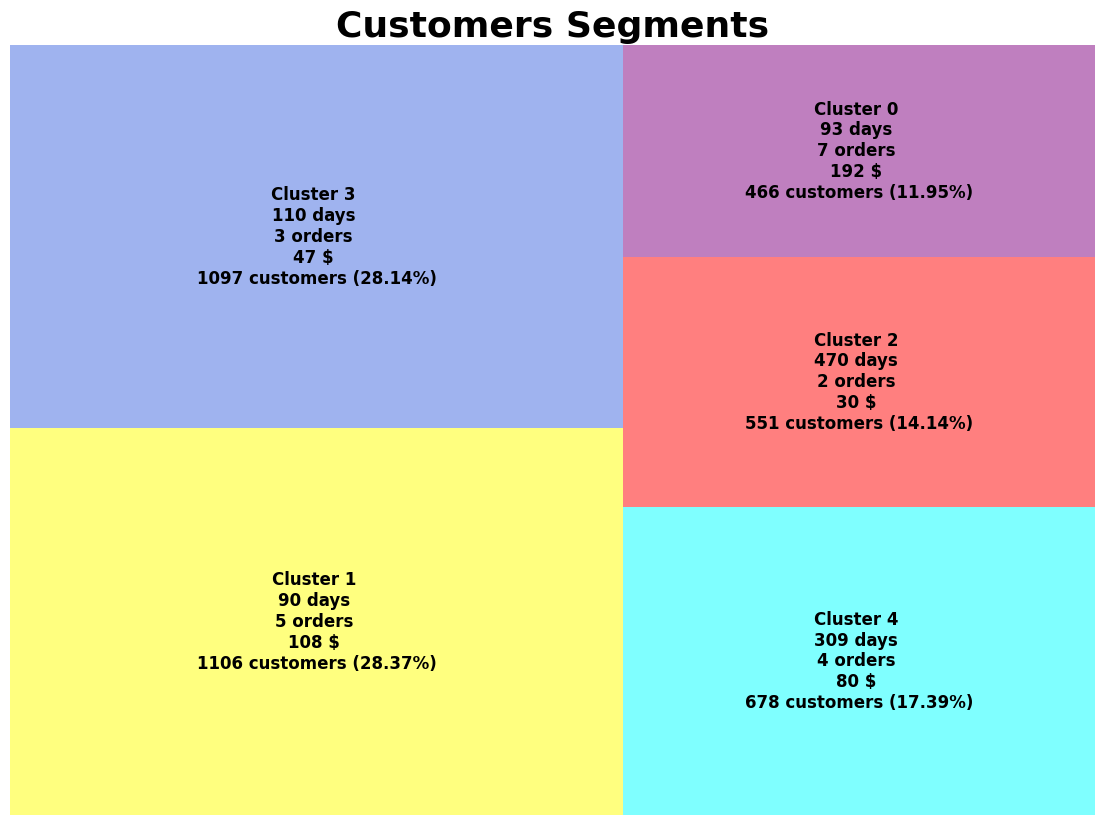

In [ ]:
# Treemap

# Convert PySpark DataFrame to Pandas for Visualization
rfm_agg_4_pd = rfm_agg_4.toPandas()

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict4 = {'Cluster0': 'yellow', 'Cluster1': 'royalblue', 'Cluster2': 'cyan', 'Cluster3': 'red', 'Cluster4': 'purple'}

squarify.plot(sizes=rfm_agg_4_pd['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict4.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_4_pd.iloc[i])
                      for i in range(0, len(rfm_agg_4_pd))], alpha=0.5)


plt.title('Customers Segments', fontsize=26, fontweight='bold')
plt.axis('off')
plt.show()

In [ ]:
# Create Scatter Plot
fig = px.scatter(rfm_agg_4_pd, x='RecencyMean', y='MonetaryMean', size='FrequencyMean', color='Cluster', hover_name='Cluster', size_max=100)
fig.show()

### RFM + KMeans (without outliers and scaling data)

In [117]:
df_kmeans_vec_scaled_wo = scaled_data_standard_wo.select('Member_number', 'Recency', 'Frequency', 'Monetary', 'rfm_features_scaled_wo')
df_kmeans_vec_scaled_wo.show(5)

+-------------+-------+---------+--------+----------------------+
|Member_number|Recency|Frequency|Monetary|rfm_features_scaled_wo|
+-------------+-------+---------+--------+----------------------+
|         3201|     33|        6|   212.4|  [-1.0104457934050...|
|         4235|     11|        7|  211.84|  [-1.1594905752449...|
|         3225|     18|        7|   211.7|  [-1.1120672355685...|
|         4666|     28|        6|  210.57|  [-1.0443196074595...|
|         2229|      8|        8|  210.51|  [-1.1798148636776...|
+-------------+-------+---------+--------+----------------------+
only showing top 5 rows



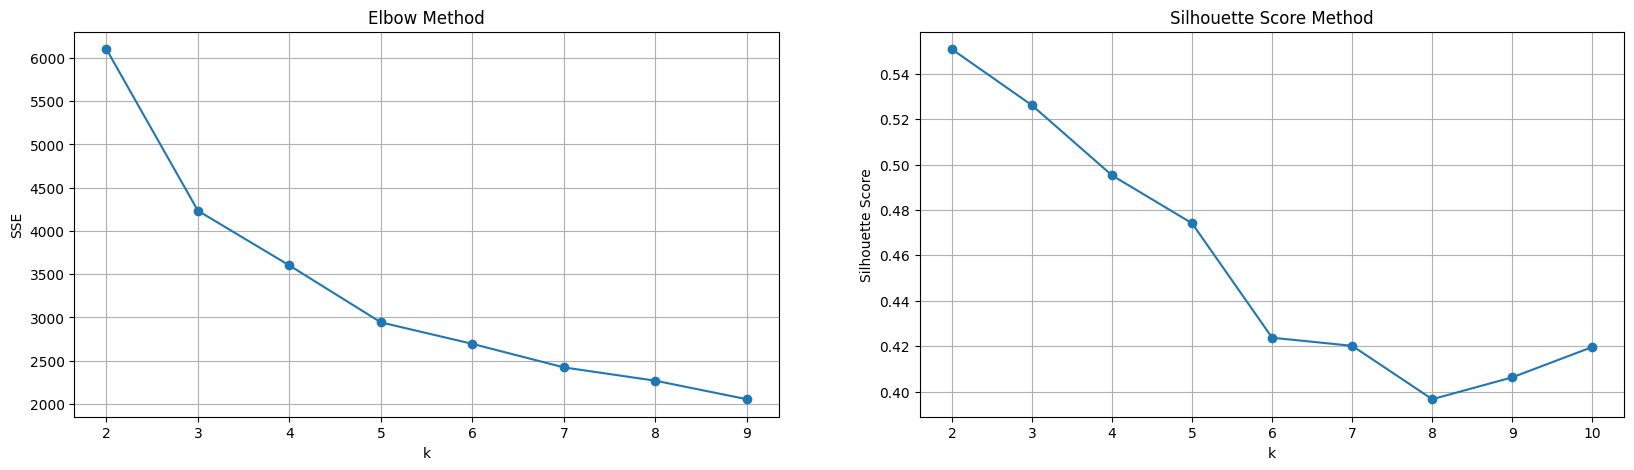

In [118]:
# Initialize empty lists for SSE and Silhouette Score
sse = {}
sil = []
kmax = 10
sil_str = ""

# Elbow Method: Compute SSE for different k-values
for k in range(2, kmax):
    kmeans = KMeans(k=k, seed=42, featuresCol='rfm_features_scaled_wo', predictionCol='cluster')
    model = kmeans.fit(df_kmeans_vec_scaled_wo)
    sse[k] = model.summary.trainingCost  # SSE (inertia in sklearn)

# Silhouette Score Method
for k in range(2, kmax + 1):  # Silhouette Score is only valid for k ≥ 2
    kmeans = KMeans(k=k, seed=42, featuresCol='rfm_features_scaled_wo', predictionCol='cluster')
    model = kmeans.fit(df_kmeans_vec_scaled_wo)
    predictions = model.transform(df_kmeans_vec_scaled_wo)

    evaluator = ClusteringEvaluator(featuresCol='rfm_features_scaled_wo', predictionCol='cluster', metricName='silhouette')
    sil_score = evaluator.evaluate(predictions)
    sil.append(sil_score)

    sil_str = sil_str + 'With k = ' + str(k) + " - Silhouette = " + str(sil_score) + '\n'

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Elbow Method Plot
ax[0].plot(list(sse.keys()), list(sse.values()), marker='o')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('k')
ax[0].set_ylabel('SSE')
ax[0].grid()

# Silhouette Score Plot
ax[1].plot(range(2, kmax + 1), sil, marker='o')
ax[1].set_title('Silhouette Score Method')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid()

plt.show()

In [119]:
print(sil_str)

With k = 2 - Silhouette = 0.5508226510490573
With k = 3 - Silhouette = 0.5261366772029535
With k = 4 - Silhouette = 0.49524643994988654
With k = 5 - Silhouette = 0.47412504454023696
With k = 6 - Silhouette = 0.42370343023258433
With k = 7 - Silhouette = 0.42013424085533874
With k = 8 - Silhouette = 0.3966028709854149
With k = 9 - Silhouette = 0.40625336670698897
With k = 10 - Silhouette = 0.41962160939219767



#### With k=6

In [120]:
# Train K-Means with k=6
kmeans_5 = KMeans(k=6, seed=42, featuresCol='rfm_features_scaled_wo', predictionCol='cluster')
model_5 = kmeans_5.fit(df_kmeans_vec_scaled_wo)

# Get cluster labels
df_clusters_5 = model_5.transform(df_kmeans_vec_scaled_wo).select('Member_number', 'Recency', 'Frequency', 'Monetary', 'cluster')

# Show cluster assignments
df_clusters_5.show(5)

+-------------+-------+---------+--------+-------+
|Member_number|Recency|Frequency|Monetary|cluster|
+-------------+-------+---------+--------+-------+
|         3201|     33|        6|   212.4|      0|
|         4235|     11|        7|  211.84|      0|
|         3225|     18|        7|   211.7|      0|
|         4666|     28|        6|  210.57|      0|
|         2229|      8|        8|  210.51|      0|
+-------------+-------+---------+--------+-------+
only showing top 5 rows



In [121]:
labels_5 = df_clusters_5.count()
print('Number of cluster assignments:', labels_5)

Number of cluster assignments: 3663


In [122]:
# Perform aggregations (mean & count)
df_cluster_summary_5 = df_clusters_5.groupBy('cluster').agg(mean('Recency').alias('Avg_Recency'),
                                                            mean('Frequency').alias('Avg_Frequency'),
                                                            mean('Monetary').alias('Avg_Monetary'), count('Member_number').alias('Count'))

# Show the result
df_cluster_summary_5.show()

+-------+------------------+------------------+------------------+-----+
|cluster|       Avg_Recency|     Avg_Frequency|      Avg_Monetary|Count|
+-------+------------------+------------------+------------------+-----+
|      1| 89.79123711340206| 2.654639175257732|48.934780927834986|  776|
|      3|303.30214424951265| 4.060428849902534|  92.1138011695906|  513|
|      5| 79.33914053426248|4.4576074332171896| 91.38412311265964|  861|
|      4|477.01069518716577|1.9786096256684491| 35.00673796791443|  374|
|      2| 270.1666666666667| 2.034136546184739|37.407811244979925|  498|
|      0| 94.66770670826833|6.0639625585023404|150.98042121684873|  641|
+-------+------------------+------------------+------------------+-----+



In [123]:
# Compute Aggregates for Each Cluster
rfm_agg_5 = df_clusters_5.groupBy('Cluster').agg(round(mean('Recency'), 0).alias('RecencyMean'),
                                                 round(mean('Frequency'), 0).alias('FrequencyMean'),
                                                 round(mean('Monetary'), 0).alias('MonetaryMean'),
                                                 count('*').alias('Count'))

# Compute Percentage of Each Cluster
total_count = df_clusters_5.count()
rfm_agg_5 = rfm_agg_5.withColumn('Percent', round((rfm_agg_5['Count'] / total_count) * 100, 2))

# Convert Cluster Labels to "Cluster X" Format
rfm_agg_5 = rfm_agg_5.withColumn('Cluster', concat(lit('Cluster '), rfm_agg_5['Cluster'].cast('string')))

# Show the Result
rfm_agg_5.show()

+---------+-----------+-------------+------------+-----+-------+
|  Cluster|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+---------+-----------+-------------+------------+-----+-------+
|Cluster 1|       90.0|          3.0|        49.0|  776|  21.18|
|Cluster 3|      303.0|          4.0|        92.0|  513|   14.0|
|Cluster 5|       79.0|          4.0|        91.0|  861|  23.51|
|Cluster 4|      477.0|          2.0|        35.0|  374|  10.21|
|Cluster 2|      270.0|          2.0|        37.0|  498|   13.6|
|Cluster 0|       95.0|          6.0|       151.0|  641|   17.5|
+---------+-----------+-------------+------------+-----+-------+



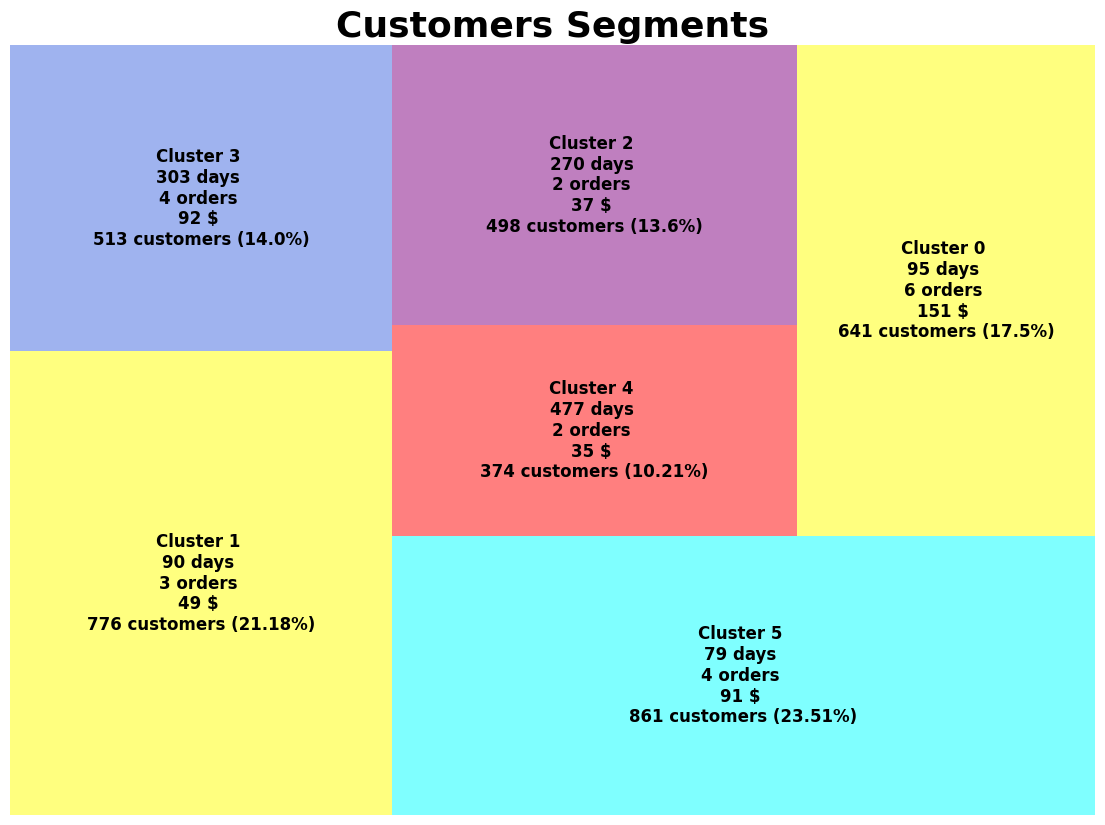

In [124]:
# Treemap

# Convert PySpark DataFrame to Pandas for Visualization
rfm_agg_5_pd = rfm_agg_5.toPandas()

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict5 = {'Cluster0': 'yellow', 'Cluster1': 'royalblue', 'Cluster2': 'cyan', 'Cluster3': 'red', 'Cluster4': 'purple'}

squarify.plot(sizes=rfm_agg_5_pd['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict5.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_5_pd.iloc[i])
                      for i in range(0, len(rfm_agg_5_pd))], alpha=0.5)


plt.title('Customers Segments', fontsize=26, fontweight='bold')
plt.axis('off')
plt.show()

In [125]:
# Create Scatter Plot
fig = px.scatter(rfm_agg_5_pd, x='RecencyMean', y='MonetaryMean', size='FrequencyMean', color='Cluster', hover_name='Cluster', size_max=100)
fig.show()

#### With k=5

In [126]:
# Train K-Means with k=5
kmeans_6 = KMeans(k=5, seed=42, featuresCol='rfm_features_scaled_wo', predictionCol='cluster')
model_6 = kmeans_6.fit(df_kmeans_vec_scaled_wo)

# Get cluster labels
df_clusters_6 = model_6.transform(df_kmeans_vec_scaled_wo).select('Member_number', 'Recency', 'Frequency', 'Monetary', 'cluster')

# Show cluster assignments
df_clusters_6.show(5)

+-------------+-------+---------+--------+-------+
|Member_number|Recency|Frequency|Monetary|cluster|
+-------------+-------+---------+--------+-------+
|         3201|     33|        6|   212.4|      2|
|         4235|     11|        7|  211.84|      2|
|         3225|     18|        7|   211.7|      2|
|         4666|     28|        6|  210.57|      2|
|         2229|      8|        8|  210.51|      2|
+-------------+-------+---------+--------+-------+
only showing top 5 rows



In [127]:
labels_6 = df_clusters_6.count()
print('Number of cluster assignments:', labels_6)

Number of cluster assignments: 3663


In [128]:
# Perform aggregations (mean & count)
df_cluster_summary_6 = df_clusters_6.groupBy('cluster').agg(mean('Recency').alias('Avg_Recency'),
                                                            mean('Frequency').alias('Avg_Frequency'),
                                                            mean('Monetary').alias('Avg_Monetary'), count('Member_number').alias('Count'))

# Show the result
df_cluster_summary_6.show()

+-------+------------------+------------------+------------------+-----+
|cluster|       Avg_Recency|     Avg_Frequency|      Avg_Monetary|Count|
+-------+------------------+------------------+------------------+-----+
|      1| 131.3487241798299| 2.301336573511543|   41.361567436209|  823|
|      3|418.19039735099335|1.9569536423841059|  35.5242549668874|  604|
|      4| 298.9644760213144|4.0444049733570155|  89.5905861456483|  563|
|      2|  94.3946251768034| 6.016973125884017|147.21916548797745|  707|
|      0| 73.98447204968944|  4.15527950310559|  85.2887060041408|  966|
+-------+------------------+------------------+------------------+-----+



In [129]:
# Compute Aggregates for Each Cluster
rfm_agg_6 = df_clusters_6.groupBy('Cluster').agg(round(mean('Recency'), 0).alias('RecencyMean'),
                                                 round(mean('Frequency'), 0).alias('FrequencyMean'),
                                                 round(mean('Monetary'), 0).alias('MonetaryMean'),
                                                 count('*').alias('Count'))

# Compute Percentage of Each Cluster
total_count = df_clusters_6.count()
rfm_agg_6 = rfm_agg_6.withColumn('Percent', round((rfm_agg_6['Count'] / total_count) * 100, 2))

# Convert Cluster Labels to "Cluster X" Format
rfm_agg_6 = rfm_agg_6.withColumn('Cluster', concat(lit('Cluster '), rfm_agg_6['Cluster'].cast('string')))

# Show the Result
rfm_agg_6.show()

+---------+-----------+-------------+------------+-----+-------+
|  Cluster|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+---------+-----------+-------------+------------+-----+-------+
|Cluster 1|      131.0|          2.0|        41.0|  823|  22.47|
|Cluster 3|      418.0|          2.0|        36.0|  604|  16.49|
|Cluster 4|      299.0|          4.0|        90.0|  563|  15.37|
|Cluster 2|       94.0|          6.0|       147.0|  707|   19.3|
|Cluster 0|       74.0|          4.0|        85.0|  966|  26.37|
+---------+-----------+-------------+------------+-----+-------+



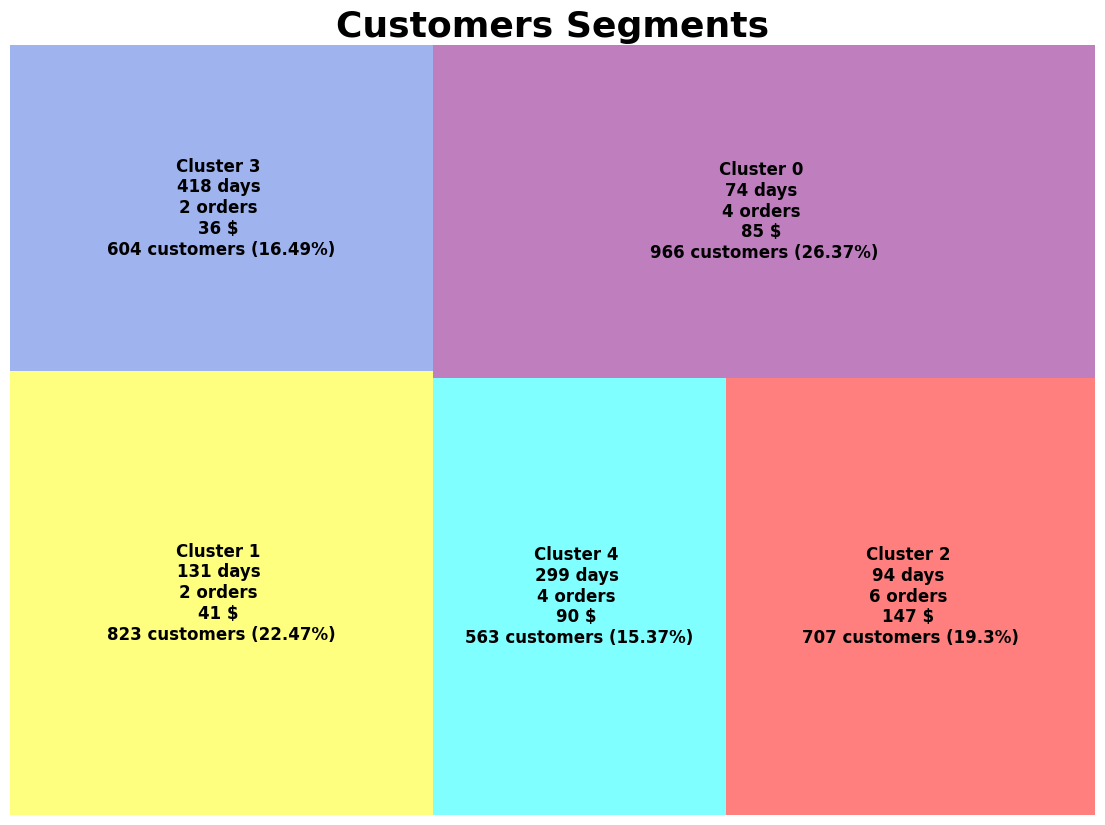

In [130]:
# Treemap

# Convert PySpark DataFrame to Pandas for Visualization
rfm_agg_6_pd = rfm_agg_6.toPandas()

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict6 = {'Cluster0': 'yellow', 'Cluster1': 'royalblue', 'Cluster2': 'cyan', 'Cluster3': 'red', 'Cluster4': 'purple'}

squarify.plot(sizes=rfm_agg_6_pd['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict6.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_6_pd.iloc[i])
                      for i in range(0, len(rfm_agg_6_pd))], alpha=0.5)


plt.title('Customers Segments', fontsize=26, fontweight='bold')
plt.axis('off')
plt.show()

In [131]:
# Create Scatter Plot
fig = px.scatter(rfm_agg_6_pd, x='RecencyMean', y='MonetaryMean', size='FrequencyMean', color='Cluster', hover_name='Cluster', size_max=100)
fig.show()

### RFM + KMeans (without outliers and no scaling data)

In [132]:
df_kmeans_wo_ns = data_rfm_cleaned.select('Member_number', 'Recency', 'Frequency', 'Monetary')
df_kmeans_wo_ns.show(5)

+-------------+-------+---------+--------+
|Member_number|Recency|Frequency|Monetary|
+-------------+-------+---------+--------+
|         3201|     33|        6|   212.4|
|         4235|     11|        7|  211.84|
|         3225|     18|        7|   211.7|
|         4666|     28|        6|  210.57|
|         2229|      8|        8|  210.51|
+-------------+-------+---------+--------+
only showing top 5 rows



In [133]:
df_kmeans_wo_ns.describe().show(5)

+-------+------------------+------------------+------------------+-----------------+
|summary|     Member_number|           Recency|         Frequency|         Monetary|
+-------+------------------+------------------+------------------+-----------------+
|  count|              3663|              3663|              3663|             3663|
|   mean|3002.4226044226043|182.14851214851214|3.7185367185367184|79.82788970788985|
| stddev|1157.6534579141226|147.60664364379306| 1.680421145362487| 46.6122387824397|
|    min|              1000|                 0|                 1|              1.1|
|    max|              5000|               602|                 8|            212.4|
+-------+------------------+------------------+------------------+-----------------+



In [134]:
vec_assembler_wo_ns = VectorAssembler(inputCols=['Recency', 'Frequency', 'Monetary'],
                                      outputCol='features_wo_ns')

In [135]:
df_kmeans_vec_wo_ns = vec_assembler_wo_ns.transform(df_kmeans_wo_ns).select('features_wo_ns')
df_kmeans_vec_wo_ns.show(5)

+-----------------+
|   features_wo_ns|
+-----------------+
| [33.0,6.0,212.4]|
|[11.0,7.0,211.84]|
| [18.0,7.0,211.7]|
|[28.0,6.0,210.57]|
| [8.0,8.0,210.51]|
+-----------------+
only showing top 5 rows



In [136]:
data_wo_ns = vec_assembler_wo_ns.transform(df_kmeans_wo_ns).select('Member_number', 'Recency', 'Frequency', 'Monetary', 'features_wo_ns')
data_wo_ns.show(5)

+-------------+-------+---------+--------+-----------------+
|Member_number|Recency|Frequency|Monetary|   features_wo_ns|
+-------------+-------+---------+--------+-----------------+
|         3201|     33|        6|   212.4| [33.0,6.0,212.4]|
|         4235|     11|        7|  211.84|[11.0,7.0,211.84]|
|         3225|     18|        7|   211.7| [18.0,7.0,211.7]|
|         4666|     28|        6|  210.57|[28.0,6.0,210.57]|
|         2229|      8|        8|  210.51| [8.0,8.0,210.51]|
+-------------+-------+---------+--------+-----------------+
only showing top 5 rows



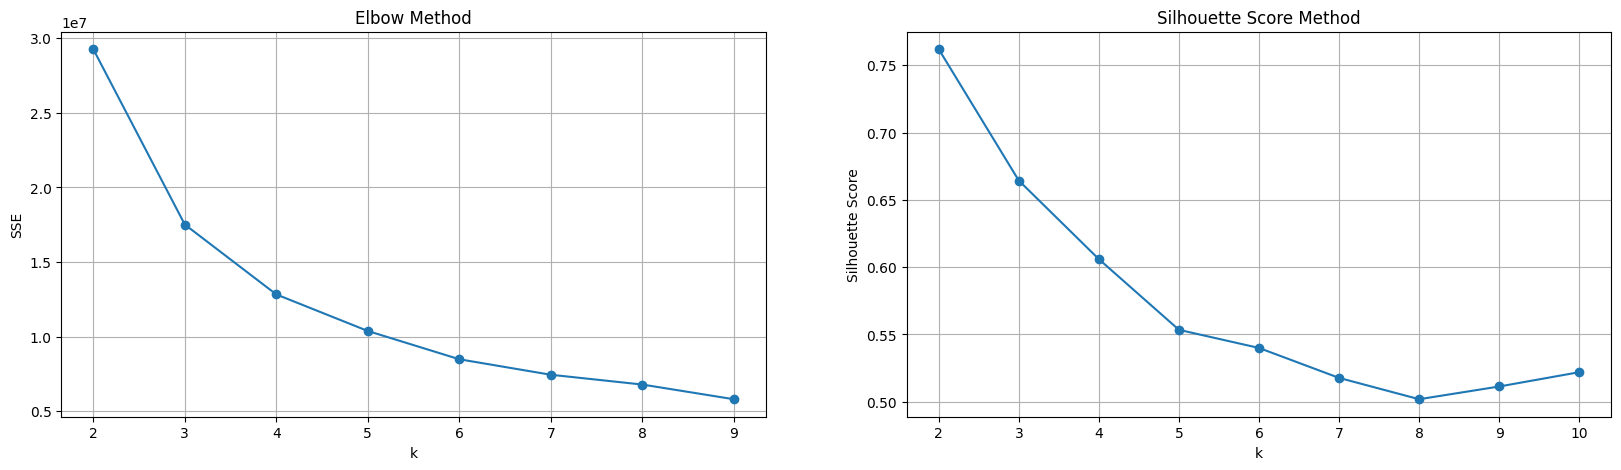

In [137]:
# Initialize empty lists for SSE and Silhouette Score
sse = {}
sil = []
kmax = 10
sil_str = ""

# Elbow Method: Compute SSE for different k-values
for k in range(2, kmax):
    kmeans = KMeans(k=k, seed=42, featuresCol='features_wo_ns', predictionCol='cluster')
    model = kmeans.fit(df_kmeans_vec_wo_ns)
    sse[k] = model.summary.trainingCost  # SSE (inertia in sklearn)

# Silhouette Score Method
for k in range(2, kmax + 1):  # Silhouette Score is only valid for k ≥ 2
    kmeans = KMeans(k=k, seed=42, featuresCol='features_wo_ns', predictionCol='cluster')
    model = kmeans.fit(df_kmeans_vec_wo_ns)
    predictions = model.transform(df_kmeans_vec_wo_ns)

    evaluator = ClusteringEvaluator(featuresCol='features_wo_ns', predictionCol='cluster', metricName='silhouette')
    sil_score = evaluator.evaluate(predictions)
    sil.append(sil_score)

    sil_str = sil_str + 'With k = ' + str(k) + " - Silhouette = " + str(sil_score) + '\n'

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Elbow Method Plot
ax[0].plot(list(sse.keys()), list(sse.values()), marker='o')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('k')
ax[0].set_ylabel('SSE')
ax[0].grid()

# Silhouette Score Plot
ax[1].plot(range(2, kmax + 1), sil, marker='o')
ax[1].set_title('Silhouette Score Method')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid()

plt.show()

In [138]:
print(sil_str)

With k = 2 - Silhouette = 0.7618975098781823
With k = 3 - Silhouette = 0.6643005984233665
With k = 4 - Silhouette = 0.60592594834269
With k = 5 - Silhouette = 0.5534260703752775
With k = 6 - Silhouette = 0.5399574399642242
With k = 7 - Silhouette = 0.517716966243209
With k = 8 - Silhouette = 0.5018724385476344
With k = 9 - Silhouette = 0.5113256613207239
With k = 10 - Silhouette = 0.5219633580293631



In [139]:
# Train K-Means with k=6
kmeans_7 = KMeans(k=6, seed=42, featuresCol='features_wo_ns', predictionCol='cluster')
model_7 = kmeans_7.fit(data_wo_ns)

# Get cluster labels
df_clusters_7 = model_7.transform(data_wo_ns).select('Member_number', 'Recency', 'Frequency', 'Monetary', 'cluster')

# Show cluster assignments
df_clusters_7.show(5)

+-------------+-------+---------+--------+-------+
|Member_number|Recency|Frequency|Monetary|cluster|
+-------------+-------+---------+--------+-------+
|         3201|     33|        6|   212.4|      0|
|         4235|     11|        7|  211.84|      0|
|         3225|     18|        7|   211.7|      0|
|         4666|     28|        6|  210.57|      0|
|         2229|      8|        8|  210.51|      0|
+-------------+-------+---------+--------+-------+
only showing top 5 rows



In [140]:
labels_7 = df_clusters_7.count()
print('Number of cluster assignments:', labels_7)

Number of cluster assignments: 3663


In [141]:
# Perform aggregations (mean & count)
df_cluster_summary_7 = df_clusters_7.groupBy('cluster').agg(mean('Recency').alias('Avg_Recency'),
                                                            mean('Frequency').alias('Avg_Frequency'),
                                                            mean('Monetary').alias('Avg_Monetary'), count('Member_number').alias('Count'))

# Show the result
df_cluster_summary_7.show()

+-------+------------------+------------------+-----------------+-----+
|cluster|       Avg_Recency|     Avg_Frequency|     Avg_Monetary|Count|
+-------+------------------+------------------+-----------------+-----+
|      1| 355.7683615819209|2.9096045197740112|58.26951035781544|  531|
|      3|136.16020671834625|3.5426356589147288|69.06697674418609|  774|
|      5|  235.759941089838| 3.695139911634757|82.72826215022089|  679|
|      4| 39.84463625154131| 3.720098643649815| 66.2679408138101|  811|
|      2| 507.2344827586207|2.1586206896551725|           41.733|  290|
|      0|57.813148788927336| 5.505190311418685|148.7755190311417|  578|
+-------+------------------+------------------+-----------------+-----+



In [142]:
# Compute Aggregates for Each Cluster
rfm_agg_7 = df_clusters_7.groupBy('Cluster').agg(round(mean('Recency'), 0).alias('RecencyMean'),
                                                 round(mean('Frequency'), 0).alias('FrequencyMean'),
                                                 round(mean('Monetary'), 0).alias('MonetaryMean'),
                                                 count('*').alias('Count'))

# Compute Percentage of Each Cluster
total_count = df_clusters_7.count()
rfm_agg_7 = rfm_agg_7.withColumn('Percent', round((rfm_agg_7['Count'] / total_count) * 100, 2))

# Convert Cluster Labels to "Cluster X" Format
rfm_agg_7 = rfm_agg_7.withColumn('Cluster', concat(lit('Cluster '), rfm_agg_7['Cluster'].cast('string')))

# Show the Result
rfm_agg_7.show()

+---------+-----------+-------------+------------+-----+-------+
|  Cluster|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+---------+-----------+-------------+------------+-----+-------+
|Cluster 1|      356.0|          3.0|        58.0|  531|   14.5|
|Cluster 3|      136.0|          4.0|        69.0|  774|  21.13|
|Cluster 5|      236.0|          4.0|        83.0|  679|  18.54|
|Cluster 4|       40.0|          4.0|        66.0|  811|  22.14|
|Cluster 2|      507.0|          2.0|        42.0|  290|   7.92|
|Cluster 0|       58.0|          6.0|       149.0|  578|  15.78|
+---------+-----------+-------------+------------+-----+-------+



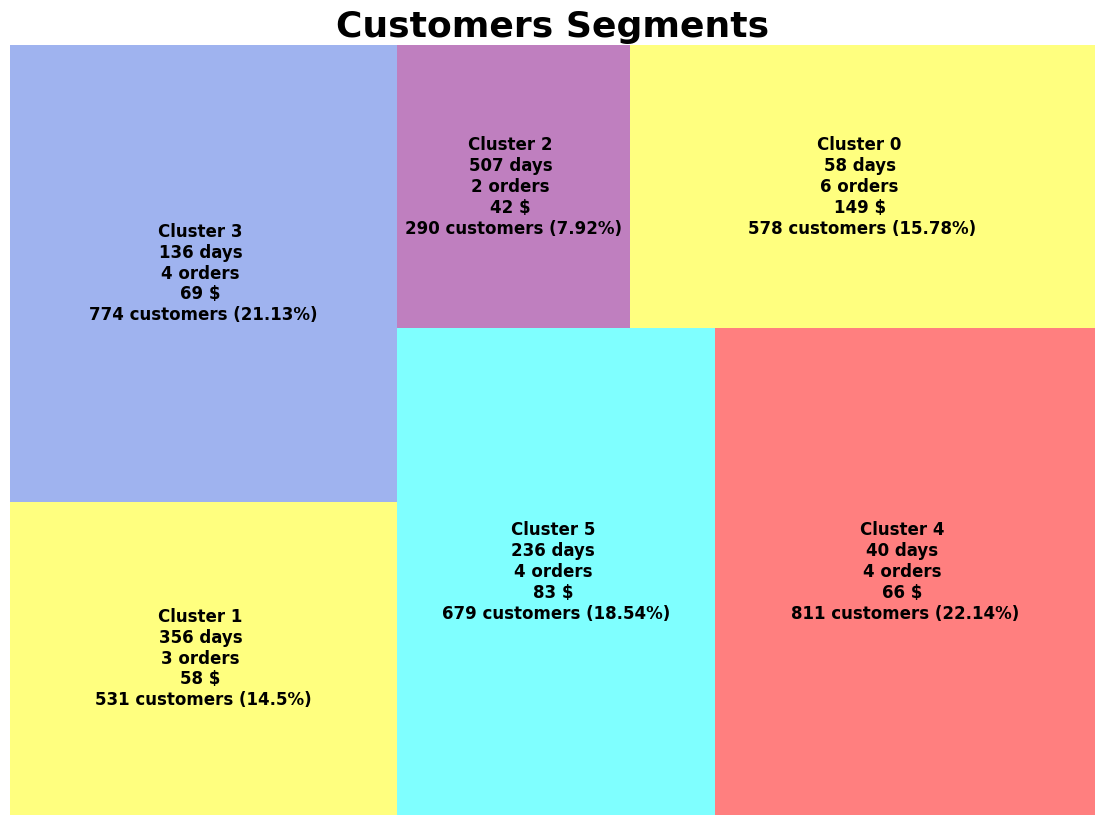

In [143]:
# Treemap

# Convert PySpark DataFrame to Pandas for Visualization
rfm_agg_7_pd = rfm_agg_7.toPandas()

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict7 = {'Cluster0': 'yellow', 'Cluster1': 'royalblue', 'Cluster2': 'cyan', 'Cluster3': 'red', 'Cluster4': 'purple'}

squarify.plot(sizes=rfm_agg_7_pd['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict7.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_7_pd.iloc[i])
                      for i in range(0, len(rfm_agg_7_pd))], alpha=0.5)


plt.title('Customers Segments', fontsize=26, fontweight='bold')
plt.axis('off')
plt.show()

In [144]:
# Create Scatter Plot
fig = px.scatter(rfm_agg_7_pd, x='RecencyMean', y='MonetaryMean', size='FrequencyMean', color='Cluster', hover_name='Cluster', size_max=100)
fig.show()

#### With k=5

In [145]:
# Train K-Means with k=5
kmeans_8 = KMeans(k=5, seed=42, featuresCol='features_wo_ns', predictionCol='cluster')
model_8 = kmeans_8.fit(data_wo_ns)

# Get cluster labels
df_clusters_8 = model_8.transform(data_wo_ns).select('Member_number', 'Recency', 'Frequency', 'Monetary', 'cluster')

# Show cluster assignments
df_clusters_8.show(5)

+-------------+-------+---------+--------+-------+
|Member_number|Recency|Frequency|Monetary|cluster|
+-------------+-------+---------+--------+-------+
|         3201|     33|        6|   212.4|      0|
|         4235|     11|        7|  211.84|      0|
|         3225|     18|        7|   211.7|      0|
|         4666|     28|        6|  210.57|      0|
|         2229|      8|        8|  210.51|      0|
+-------------+-------+---------+--------+-------+
only showing top 5 rows



In [146]:
labels_8 = df_clusters_8.count()
print('Number of cluster assignments:', labels_8)

Number of cluster assignments: 3663


In [147]:
# Perform aggregations (mean & count)
df_cluster_summary_8 = df_clusters_8.groupBy('cluster').agg(mean('Recency').alias('Avg_Recency'),
                                                            mean('Frequency').alias('Avg_Frequency'),
                                                            mean('Monetary').alias('Avg_Monetary'), count('Member_number').alias('Count'))

# Show the result
df_cluster_summary_8.show()

+-------+------------------+------------------+------------------+-----+
|cluster|       Avg_Recency|     Avg_Frequency|      Avg_Monetary|Count|
+-------+------------------+------------------+------------------+-----+
|      1| 326.7543604651163|3.0305232558139537| 64.01529069767435|  688|
|      3|182.89579158316633| 3.714428857715431| 78.09331663326643|  998|
|      4|55.366632337796084| 3.568486096807415| 62.22610710607621|  971|
|      2|494.26099706744867|2.2140762463343107| 42.58322580645159|  341|
|      0| 56.49473684210526| 5.427067669172932|143.59019548872175|  665|
+-------+------------------+------------------+------------------+-----+



In [148]:
# Compute Aggregates for Each Cluster
rfm_agg_8 = df_clusters_8.groupBy('Cluster').agg(round(mean('Recency'), 0).alias('RecencyMean'),
                                                 round(mean('Frequency'), 0).alias('FrequencyMean'),
                                                 round(mean('Monetary'), 0).alias('MonetaryMean'),
                                                 count('*').alias('Count'))

# Compute Percentage of Each Cluster
total_count = df_clusters_8.count()
rfm_agg_8 = rfm_agg_8.withColumn('Percent', round((rfm_agg_8['Count'] / total_count) * 100, 2))

# Convert Cluster Labels to "Cluster X" Format
rfm_agg_8 = rfm_agg_8.withColumn('Cluster', concat(lit('Cluster '), rfm_agg_8['Cluster'].cast('string')))

# Show the Result
rfm_agg_8.show()

+---------+-----------+-------------+------------+-----+-------+
|  Cluster|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+---------+-----------+-------------+------------+-----+-------+
|Cluster 1|      327.0|          3.0|        64.0|  688|  18.78|
|Cluster 3|      183.0|          4.0|        78.0|  998|  27.25|
|Cluster 4|       55.0|          4.0|        62.0|  971|  26.51|
|Cluster 2|      494.0|          2.0|        43.0|  341|   9.31|
|Cluster 0|       56.0|          5.0|       144.0|  665|  18.15|
+---------+-----------+-------------+------------+-----+-------+



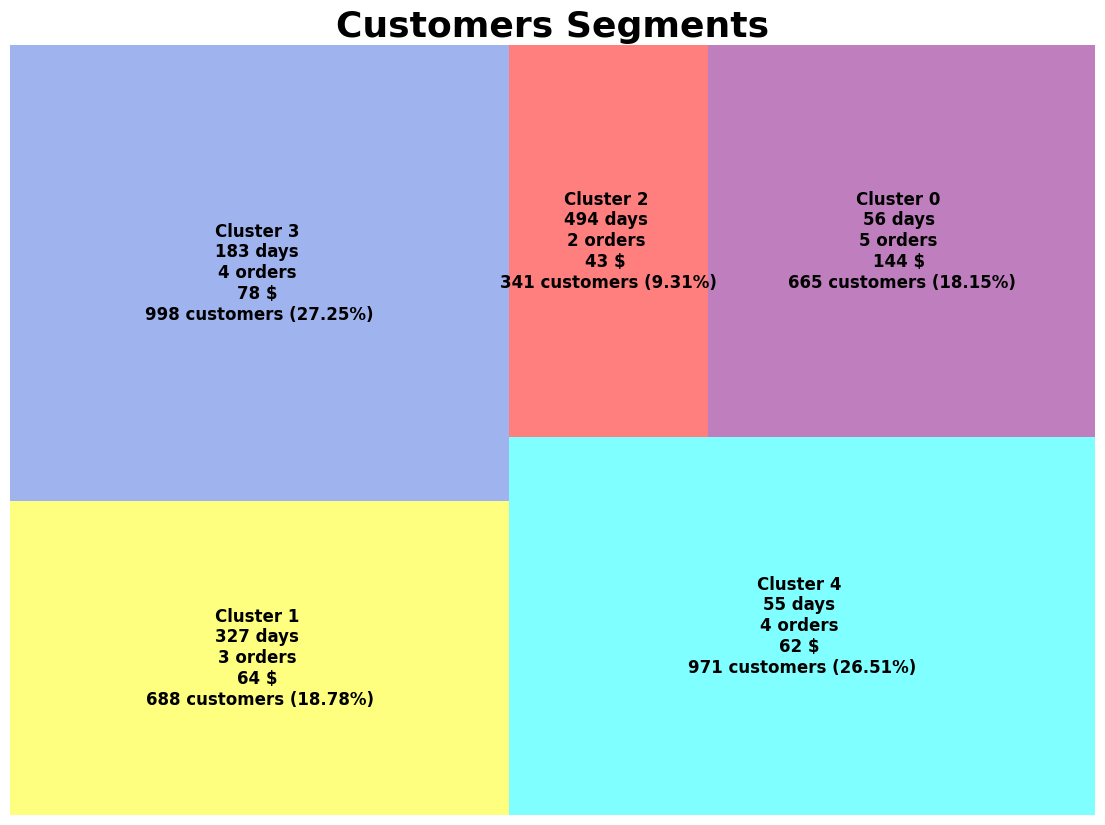

In [149]:
# Treemap

# Convert PySpark DataFrame to Pandas for Visualization
rfm_agg_8_pd = rfm_agg_8.toPandas()

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict8 = {'Cluster0': 'yellow', 'Cluster1': 'royalblue', 'Cluster2': 'cyan', 'Cluster3': 'red', 'Cluster4': 'purple'}

squarify.plot(sizes=rfm_agg_8_pd['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict8.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_8_pd.iloc[i])
                      for i in range(0, len(rfm_agg_8_pd))], alpha=0.5)


plt.title('Customers Segments', fontsize=26, fontweight='bold')
plt.axis('off')
plt.show()

In [150]:
# Create Scatter Plot
fig = px.scatter(rfm_agg_8_pd, x='RecencyMean', y='MonetaryMean', size='FrequencyMean', color='Cluster', hover_name='Cluster', size_max=100)
fig.show()

- Nhận xét: mô hình RFM + KMeans không bỏ outliers và không chuẩn hóa dữ liệu cho kết quả cao nhất